Import important parameter

In [1]:
inputsize = 49
e = 0.0063

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for i in range(outputsize):
            OUTPUT[i][2*i] = 1/4
            OUTPUT[i][1+2*i] = 1/2
            OUTPUT[i][2+2*i] = 1/4
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    A1 = 2*np.eye(inputsize)
    for i in range(inputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    OUTPUT = A1
    return OUTPUT

def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 2.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 2.*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <20000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
MAX_ITER = 50
def u_real(x): return np.sin(4.*np.pi*x)
def rightf(x): return  -4*np.pi**2*np.cos(4*np.pi*x)*np.cos(np.pi*x/e)/e+16*(np.pi**2)*(2+np.sin(np.pi*x/e))*np.sin(4*np.pi*x)
def a(x): return 2+np.sin(np.pi*x/e)
outputsize = int(inputsize/2)
h = 1/(inputsize-1)
X = np.linspace(0, 1, inputsize)
H = 1/(outputsize-1)
Media = a(np.linspace(-h,1+h,inputsize+1))
A0 = Poisson(inputsize)
A1 = gallery.divkrad((inputsize,),Media)
RightF = rightf(X)*h**2
RightF = RightF.reshape(inputsize, 1)
UREAL = u_real(X).reshape(inputsize, 1)
R = Restriction(inputsize)
P = 2.*np.transpose(R)

In [5]:
num_levels = 2
n = inputsize
linear_gmg = gmg_linear.LinearGMG(A1, max_levels=num_levels)
print("Linear = {}".format(linear_gmg.compute_rho()))

Linear = 0.6470063251525742


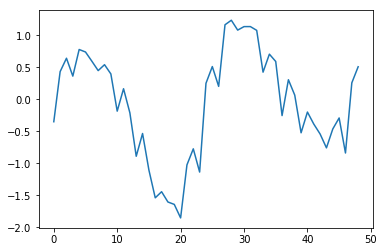

In [6]:
gmmx = linear_gmg.solve(RightF,np.zeros(A1.shape),tol=1e-12)
plt.plot(gmmx)

In [7]:
print("Relative error = {}".format(np.linalg.norm(gmmx - UREAL) / 
                                   np.linalg.norm(UREAL)))

Relative error = 0.6173742542433421


Local DMM on fine grid

In [8]:
K = 10
batch_size = 10
num_iter = 4000
step_size = 5e-5
PR_stencil_type = "m3p"
init_point = None
convergence = {}
opt_par_n = {}
conv_time = {}
deep_gmm = dgmg.DeepMG(A1, K=K, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
opt_par = deep_gmm.optimize(num_iter=num_iter, step_size=step_size, batch_size=batch_size, init_point=init_point)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Iteration 100/4000
Upper bound estimation = 0.7135911911621543
Iteration 200/4000
Upper bound estimation = 0.6943849432865503
Iteration 300/4000
Upper bound estimation = 0.672575792807915
Iteration 400/4000
Upper bound estimation = 0.6468512268921955
Iteration 500/4000
Upper bound estimation = 0.6319783989335173
Iteration 600/4000
Upper bound estimation = 0.6124426393910042
Iteration 700/4000
Upper bound estimation = 0.5943099048717175
Iteration 800/4000
Upper bound estimation = 0.5609131673961044
Iteration 900/4000
Upper bound estimation = 0.5623318948183681
Iteration 1000/4000
Upper bound estimation = 0.5496716632410329
Iteration 1100/4000
Upper bound estimation = 0.539430836315064
Iteration 1200/4000
Upper bound estimation = 0.5182260802525879
Iteration 1300/4000
Upper bound estimation = 0.5004473931773246
Iteration 1400/4000
Upper bound estimation = 0.5058373383426952
Iteration 1500/4000
Upper bound estimation = 0.49425680759551816
Iteration 1600/4000
Upper bound estimation = 0.496

In [9]:
deep_gmm.update_prd(opt_par)  
current_rho = deep_gmm.compute_rho()
print("Optimized rho = {}".format(current_rho))

Optimized rho = 0.32950637420121826


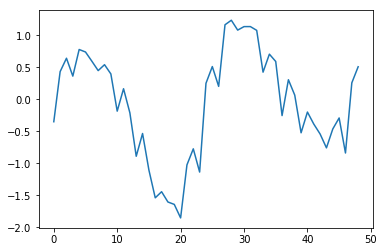

In [10]:
dmmx = deep_gmm.solve(RightF,np.zeros(A1.shape) ,tol=1e-12)
plt.plot(gmmx)

In [11]:
print("Relative error = {}".format(np.linalg.norm(dmmx - UREAL) / 
                                   np.linalg.norm(UREAL)))

Relative error = 0.6173742542435346


In [12]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, learning_rate = 1e-6,accept_radius = 1 ,step_length = 1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.11973590136183483
L = 0.03
rho = 0.12138198648183772
L = 0.04
rho = 0.12351566157526972
L = 0.05
rho = 0.12586330789938624
L = 0.060000000000000005
rho = 0.12830375821347645
L = 0.07
rho = 0.13078641747754807
L = 0.08
rho = 0.13328958626192433
L = 0.09
rho = 0.13580323570861388
L = 0.09999999999999999
rho = 0.13832216358908617
L = 0.10999999999999999
rho = 0.1408432482766436
L = 0.11999999999999998
rho = 0.1433643211743277
L = 0.12999999999999998
rho = 0.1458836915992466
L = 0.13999999999999999
rho = 0.14839994118744976
L = 0.15
rho = 0.15091183226102173
L = 0.16
rho = 0.15341826537100495
L = 0.17
rho = 0.15591825839352316
L = 0.18000000000000002
rho = 0.1584109351527742
L = 0.19000000000000003
rho = 0.16089551824574494
L = 0.20000000000000004
rho = 0.1633713236861569
L = 0.21000000000000005
rho = 0.1658377563017662
L = 0.22000000000000006
rho = 0.16829430541571738
L = 0.23000000000000007
rho = 0.1707405406139015
L = 0.24000000000000007
rho = 0.17

the 39 steps
rho = 0.3340682021270579
the 40 steps
rho = 0.33406331079272933
the 41 steps
rho = 0.33405843431386556
the 42 steps
rho = 0.33405357255047247
the 43 steps
rho = 0.33404872536395586
the 44 steps
rho = 0.3340438926171075
the 45 steps
rho = 0.3340390741740911
the 46 steps
rho = 0.3340342699004294
the 47 steps
rho = 0.33402947966298663
the 48 steps
rho = 0.33402470332995854
the 49 steps
rho = 0.3340199407708542
the 50 steps
rho = 0.3340151918564882
the 51 steps
rho = 0.3340104564589608
the 52 steps
rho = 0.3340057344516475
the 53 steps
rho = 0.3340010257091896
the 54 steps
rho = 0.3339963301074729
the 55 steps
rho = 0.3339916475236243
the 56 steps
rho = 0.3339869778359879
the 57 steps
rho = 0.33398232092412483
the 58 steps
rho = 0.3339776766687917
the 59 steps
rho = 0.33397304495193186
the 60 steps
rho = 0.3339684256566626
the 61 steps
rho = 0.3339638186672611
the 62 steps
rho = 0.3339592238691571
the 63 steps
rho = 0.3339546411489188
the 64 steps
rho = 0.3339500703942361
the 

the 184 steps
rho = 0.3334633892222687
the 185 steps
rho = 0.3334596928876718
the 186 steps
rho = 0.33345600060421093
the 187 steps
rho = 0.3334523123385119
the 188 steps
rho = 0.33344862805752096
the 189 steps
rho = 0.33344494772851074
the 190 steps
rho = 0.3334412713190708
the 191 steps
rho = 0.33343759879710655
the 192 steps
rho = 0.33343393013083467
the 193 steps
rho = 0.33343026528878567
the 194 steps
rho = 0.3334266042397928
the 195 steps
rho = 0.33342294695299635
the 196 steps
rho = 0.3334192933978342
the 197 steps
rho = 0.3334156435440426
the 198 steps
rho = 0.3334119973616531
the 199 steps
rho = 0.333408354820989
the 200 steps
rho = 0.33340471589266235
the 201 steps
rho = 0.3334010805475727
the 202 steps
rho = 0.3333974487569003
the 203 steps
rho = 0.3333938204921085
the 204 steps
rho = 0.33339019572493506
the 205 steps
rho = 0.33338657442739855
the 206 steps
rho = 0.3333829565717824
the 207 steps
rho = 0.3333793421306454
the 208 steps
rho = 0.3333757310768122
the 209 steps
rh

the 329 steps
rho = 0.3329575626626339
the 330 steps
rho = 0.33295422331007946
the 331 steps
rho = 0.3329508854032215
the 332 steps
rho = 0.33294754893383693
the 333 steps
rho = 0.3329442138937753
the 334 steps
rho = 0.33294088027496715
the 335 steps
rho = 0.33293754806941733
the 336 steps
rho = 0.33293421726920147
the 337 steps
rho = 0.33293088786647423
the 338 steps
rho = 0.3329275598534613
the 339 steps
rho = 0.3329242332224584
the 340 steps
rho = 0.3329209079658387
the 341 steps
rho = 0.3329175840760422
the 342 steps
rho = 0.3329142615455786
the 343 steps
rho = 0.33291094036703023
the 344 steps
rho = 0.33290762053304707
the 345 steps
rho = 0.3329043020363468
the 346 steps
rho = 0.332900984869714
the 347 steps
rho = 0.33289766902600276
the 348 steps
rho = 0.3328943544981312
the 349 steps
rho = 0.33289104127908364
the 350 steps
rho = 0.3328877293619094
the 351 steps
rho = 0.3328844187397211
the 352 steps
rho = 0.33288110940569676
the 353 steps
rho = 0.3328778013530757
the 354 steps
r

the 471 steps
rho = 0.33249497561303304
the 472 steps
rho = 0.33249178547211006
the 473 steps
rho = 0.3324885961170825
the 474 steps
rho = 0.3324854075455725
the 475 steps
rho = 0.3324822197552299
the 476 steps
rho = 0.3324790327437125
the 477 steps
rho = 0.33247584650870743
the 478 steps
rho = 0.3324726610479117
the 479 steps
rho = 0.3324694763590432
the 480 steps
rho = 0.33246629243983683
the 481 steps
rho = 0.33246310928804823
the 482 steps
rho = 0.3324599269014433
the 483 steps
rho = 0.3324567452778104
the 484 steps
rho = 0.3324535644149537
the 485 steps
rho = 0.3324503843106935
the 486 steps
rho = 0.33244720496286767
the 487 steps
rho = 0.33244402636932985
the 488 steps
rho = 0.3324408485279495
the 489 steps
rho = 0.3324376714366116
the 490 steps
rho = 0.33243449509322065
the 491 steps
rho = 0.33243131949569293
the 492 steps
rho = 0.3324281446419615
the 493 steps
rho = 0.33242497052997677
the 494 steps
rho = 0.3324217971577013
the 495 steps
rho = 0.3324186245231154
the 496 steps
r

the 611 steps
rho = 0.332055162369314
the 612 steps
rho = 0.33205206526761843
the 613 steps
rho = 0.3320489687398727
the 614 steps
rho = 0.33204587278512054
the 615 steps
rho = 0.33204277740241667
the 616 steps
rho = 0.33203968259081107
the 617 steps
rho = 0.3320365883493677
the 618 steps
rho = 0.33203349467714754
the 619 steps
rho = 0.33203040157322233
the 620 steps
rho = 0.33202730903666494
the 621 steps
rho = 0.33202421706655416
the 622 steps
rho = 0.3320211256619727
the 623 steps
rho = 0.33201803482200726
the 624 steps
rho = 0.33201494454575003
the 625 steps
rho = 0.33201185483229784
the 626 steps
rho = 0.33200876568075255
the 627 steps
rho = 0.332005677090216
the 628 steps
rho = 0.3320025890598009
the 629 steps
rho = 0.3319995015886187
the 630 steps
rho = 0.33199641467578855
the 631 steps
rho = 0.33199332832043166
the 632 steps
rho = 0.3319902425216729
the 633 steps
rho = 0.33198715727864647
the 634 steps
rho = 0.3319840725904826
the 635 steps
rho = 0.33198098845632285
the 636 ste

the 756 steps
rho = 0.3316116677679156
the 757 steps
rho = 0.33160864574230614
the 758 steps
rho = 0.3316056241871894
the 759 steps
rho = 0.3316026031020199
the 760 steps
rho = 0.3315995824862513
the 761 steps
rho = 0.33159656233933976
the 762 steps
rho = 0.33159354266074337
the 763 steps
rho = 0.3315905234499229
the 764 steps
rho = 0.3315875047063363
the 765 steps
rho = 0.3315844864294484
the 766 steps
rho = 0.3315814686187217
the 767 steps
rho = 0.33157845127362234
the 768 steps
rho = 0.3315754343936164
the 769 steps
rho = 0.33157241797817244
the 770 steps
rho = 0.33156940202676033
the 771 steps
rho = 0.33156638653885057
the 772 steps
rho = 0.3315633715139156
the 773 steps
rho = 0.3315603569514309
the 774 steps
rho = 0.33155734285087046
the 775 steps
rho = 0.33155432921171246
the 776 steps
rho = 0.3315513160334336
the 777 steps
rho = 0.3315483033155128
the 778 steps
rho = 0.33154529105743397
the 779 steps
rho = 0.33154227925867646
the 780 steps
rho = 0.3315392679187235
the 781 steps


the 925 steps
rho = 0.33110723450537327
the 926 steps
rho = 0.33110428520176527
the 927 steps
rho = 0.3311013362925329
the 928 steps
rho = 0.3310983877772998
the 929 steps
rho = 0.3310954396556898
the 930 steps
rho = 0.3310924919273267
the 931 steps
rho = 0.3310895445918359
the 932 steps
rho = 0.33108659764884435
the 933 steps
rho = 0.33108365109797777
the 934 steps
rho = 0.3310807049388638
the 935 steps
rho = 0.33107775917113
the 936 steps
rho = 0.3310748137944055
the 937 steps
rho = 0.33107186880831774
the 938 steps
rho = 0.33106892421249906
the 939 steps
rho = 0.33106598000657844
the 940 steps
rho = 0.3310630361901862
the 941 steps
rho = 0.3310600927629563
the 942 steps
rho = 0.3310571497245196
the 943 steps
rho = 0.33105420707451005
the 944 steps
rho = 0.33105126481255986
the 945 steps
rho = 0.33104832293830655
the 946 steps
rho = 0.331045381451381
the 947 steps
rho = 0.3310424403514212
the 948 steps
rho = 0.3310394996380629
the 949 steps
rho = 0.33103655931094295
the 950 steps
rho

the 1063 steps
rho = 0.3307038060706714
the 1064 steps
rho = 0.3307009078872505
the 1065 steps
rho = 0.33069801005171134
the 1066 steps
rho = 0.3306951125637534
the 1067 steps
rho = 0.3306922154230766
the 1068 steps
rho = 0.33068931862937806
the 1069 steps
rho = 0.3306864221823588
the 1070 steps
rho = 0.3306835260817198
the 1071 steps
rho = 0.33068063032716033
the 1072 steps
rho = 0.33067773491838054
the 1073 steps
rho = 0.33067483985508606
the 1074 steps
rho = 0.3306719451369742
the 1075 steps
rho = 0.33066905076375114
the 1076 steps
rho = 0.33066615673511646
the 1077 steps
rho = 0.33066326305077626
the 1078 steps
rho = 0.33066036971043383
the 1079 steps
rho = 0.33065747671379153
the 1080 steps
rho = 0.33065458406055565
the 1081 steps
rho = 0.3306516917504305
the 1082 steps
rho = 0.3306487997831216
the 1083 steps
rho = 0.330645908158335
the 1084 steps
rho = 0.3306430168757777
the 1085 steps
rho = 0.3306401259351564
the 1086 steps
rho = 0.33063723533617756
the 1087 steps
rho = 0.330634

the 1204 steps
rho = 0.3302984645490106
the 1205 steps
rho = 0.3302956126302901
the 1206 steps
rho = 0.3302927610209221
the 1207 steps
rho = 0.33028990972066025
the 1208 steps
rho = 0.33028705872925695
the 1209 steps
rho = 0.3302842080464661
the 1210 steps
rho = 0.3302813576720394
the 1211 steps
rho = 0.3302785076057328
the 1212 steps
rho = 0.3302756578472994
the 1213 steps
rho = 0.3302728083964959
the 1214 steps
rho = 0.3302699592530738
the 1215 steps
rho = 0.33026711041679185
the 1216 steps
rho = 0.33026426188740415
the 1217 steps
rho = 0.3302614136646655
the 1218 steps
rho = 0.33025856574833334
the 1219 steps
rho = 0.33025571813816484
the 1220 steps
rho = 0.33025287083391575
the 1221 steps
rho = 0.33025002383534413
the 1222 steps
rho = 0.33024717714220625
the 1223 steps
rho = 0.33024433075426185
the 1224 steps
rho = 0.3302414846712676
the 1225 steps
rho = 0.33023863889298355
the 1226 steps
rho = 0.33023579341916787
the 1227 steps
rho = 0.3302329482495767
the 1228 steps
rho = 0.33023

the 1386 steps
rho = 0.32978427991354387
the 1387 steps
rho = 0.32978148052329276
the 1388 steps
rho = 0.32977868140224914
the 1389 steps
rho = 0.3297758825502147
the 1390 steps
rho = 0.3297730839669941
the 1391 steps
rho = 0.32977028565238903
the 1392 steps
rho = 0.32976748760620594
the 1393 steps
rho = 0.32976468982824925
the 1394 steps
rho = 0.32976189231832337
the 1395 steps
rho = 0.3297590950762334
the 1396 steps
rho = 0.3297562981017839
the 1397 steps
rho = 0.32975350139478155
the 1398 steps
rho = 0.32975070495503067
the 1399 steps
rho = 0.3297479087823384
the 1400 steps
rho = 0.3297451128765114
the 1401 steps
rho = 0.32974231723735536
the 1402 steps
rho = 0.32973952186467687
the 1403 steps
rho = 0.32973672675828236
the 1404 steps
rho = 0.32973393191798017
the 1405 steps
rho = 0.329731137343577
the 1406 steps
rho = 0.3297283430348792
the 1407 steps
rho = 0.32972554899169704
the 1408 steps
rho = 0.329722755213836
the 1409 steps
rho = 0.32971996170110607
the 1410 steps
rho = 0.3297

the 1549 steps
rho = 0.32933140083671375
the 1550 steps
rho = 0.3293286428910816
the 1551 steps
rho = 0.3293258851855053
the 1552 steps
rho = 0.3293231277198235
the 1553 steps
rho = 0.329320370493874
the 1554 steps
rho = 0.32931761350749156
the 1555 steps
rho = 0.3293148567605164
the 1556 steps
rho = 0.3293121002527871
the 1557 steps
rho = 0.3293093439841419
the 1558 steps
rho = 0.32930658795441725
the 1559 steps
rho = 0.32930383216345516
the 1560 steps
rho = 0.3293010766110906
the 1561 steps
rho = 0.3292983212971652
the 1562 steps
rho = 0.3292955662215179
the 1563 steps
rho = 0.3292928113839883
the 1564 steps
rho = 0.32929005678441564
the 1565 steps
rho = 0.32928730242263826
the 1566 steps
rho = 0.3292845482984986
the 1567 steps
rho = 0.3292817944118359
the 1568 steps
rho = 0.329279040762489
the 1569 steps
rho = 0.32927628735030107
the 1570 steps
rho = 0.3292735341751095
the 1571 steps
rho = 0.3292707812367577
the 1572 steps
rho = 0.32926802853508497
the 1573 steps
rho = 0.32926527606

the 1729 steps
rho = 0.3288386898000069
the 1730 steps
rho = 0.3288359726075324
the 1731 steps
rho = 0.3288332556285224
the 1732 steps
rho = 0.3288305388628451
the 1733 steps
rho = 0.3288278223103652
the 1734 steps
rho = 0.32882510597094916
the 1735 steps
rho = 0.3288223898444644
the 1736 steps
rho = 0.32881967393077505
the 1737 steps
rho = 0.3288169582297506
the 1738 steps
rho = 0.32881424274125565
the 1739 steps
rho = 0.32881152746515835
the 1740 steps
rho = 0.32880881240132664
the 1741 steps
rho = 0.32880609754962575
the 1742 steps
rho = 0.32880338290992456
the 1743 steps
rho = 0.32880066848209033
the 1744 steps
rho = 0.32879795426598907
the 1745 steps
rho = 0.32879524026149126
the 1746 steps
rho = 0.32879252646846335
the 1747 steps
rho = 0.32878981288677284
the 1748 steps
rho = 0.3287870995162898
the 1749 steps
rho = 0.32878438635688195
the 1750 steps
rho = 0.32878167340841613
the 1751 steps
rho = 0.32877896067076334
the 1752 steps
rho = 0.3287762481437891
the 1753 steps
rho = 0.32

the 1866 steps
rho = 0.3284683687821974
the 1867 steps
rho = 0.3284656796417882
the 1868 steps
rho = 0.32846299069770324
the 1869 steps
rho = 0.32846030194982634
the 1870 steps
rho = 0.32845761339803936
the 1871 steps
rho = 0.3284549250422289
the 1872 steps
rho = 0.32845223688227626
the 1873 steps
rho = 0.3284495489180667
the 1874 steps
rho = 0.32844686114948235
the 1875 steps
rho = 0.32844417357640726
the 1876 steps
rho = 0.3284414861987281
the 1877 steps
rho = 0.3284387990163273
the 1878 steps
rho = 0.32843611202908973
the 1879 steps
rho = 0.3284334252369001
the 1880 steps
rho = 0.3284307386396418
the 1881 steps
rho = 0.32842805223720095
the 1882 steps
rho = 0.32842536602946093
the 1883 steps
rho = 0.328422680016308
the 1884 steps
rho = 0.328419994197627
the 1885 steps
rho = 0.3284173085733022
the 1886 steps
rho = 0.3284146231432208
the 1887 steps
rho = 0.3284119379072667
the 1888 steps
rho = 0.3284092528653243
the 1889 steps
rho = 0.32840656801728124
the 1890 steps
rho = 0.328403883

the 2004 steps
rho = 0.3280990748820339
the 2005 steps
rho = 0.3280964117790132
the 2006 steps
rho = 0.32809374885724907
the 2007 steps
rho = 0.3280910861166377
the 2008 steps
rho = 0.32808842355707846
the 2009 steps
rho = 0.32808576117846794
the 2010 steps
rho = 0.3280830989807056
the 2011 steps
rho = 0.32808043696369066
the 2012 steps
rho = 0.3280777751273211
the 2013 steps
rho = 0.3280751134714928
the 2014 steps
rho = 0.32807245199610724
the 2015 steps
rho = 0.3280697907010632
the 2016 steps
rho = 0.328067129586259
the 2017 steps
rho = 0.3280644686515928
the 2018 steps
rho = 0.3280618078969634
the 2019 steps
rho = 0.3280591473222711
the 2020 steps
rho = 0.32805648692741485
the 2021 steps
rho = 0.32805382671229355
the 2022 steps
rho = 0.3280511666768067
the 2023 steps
rho = 0.32804850682085324
the 2024 steps
rho = 0.32804584714433327
the 2025 steps
rho = 0.32804318764714674
the 2026 steps
rho = 0.32804052832919417
the 2027 steps
rho = 0.32803786919037486
the 2028 steps
rho = 0.328035

the 2142 steps
rho = 0.3277332377034493
the 2143 steps
rho = 0.3277305986890165
the 2144 steps
rho = 0.3277279598426269
the 2145 steps
rho = 0.3277253211641907
the 2146 steps
rho = 0.3277226826536185
the 2147 steps
rho = 0.32772004431082047
the 2148 steps
rho = 0.32771740613570766
the 2149 steps
rho = 0.3277147681281896
the 2150 steps
rho = 0.32771213028817847
the 2151 steps
rho = 0.32770949261558296
the 2152 steps
rho = 0.3277068551103172
the 2153 steps
rho = 0.3277042177722891
the 2154 steps
rho = 0.3277015806014102
the 2155 steps
rho = 0.327698943597594
the 2156 steps
rho = 0.3276963067607497
the 2157 steps
rho = 0.3276936700907894
the 2158 steps
rho = 0.32769103358762375
the 2159 steps
rho = 0.3276883972511646
the 2160 steps
rho = 0.32768576108132386
the 2161 steps
rho = 0.3276831250780127
the 2162 steps
rho = 0.32768048924114324
the 2163 steps
rho = 0.327677853570626
the 2164 steps
rho = 0.32767521806637384
the 2165 steps
rho = 0.3276725827282996
the 2166 steps
rho = 0.32766994755

the 2324 steps
rho = 0.3272556198094544
the 2325 steps
rho = 0.32725300997969325
the 2326 steps
rho = 0.32725040030293123
the 2327 steps
rho = 0.3272477907790936
the 2328 steps
rho = 0.32724518140810216
the 2329 steps
rho = 0.3272425721898833
the 2330 steps
rho = 0.32723996312436054
the 2331 steps
rho = 0.3272373542114593
the 2332 steps
rho = 0.32723474545110137
the 2333 steps
rho = 0.3272321368432143
the 2334 steps
rho = 0.3272295283877193
the 2335 steps
rho = 0.3272269200845431
the 2336 steps
rho = 0.32722431193360996
the 2337 steps
rho = 0.3272217039348444
the 2338 steps
rho = 0.327219096088171
the 2339 steps
rho = 0.3272164883935146
the 2340 steps
rho = 0.32721388085079983
the 2341 steps
rho = 0.32721127345995205
the 2342 steps
rho = 0.3272086662208958
the 2343 steps
rho = 0.3272060591335577
the 2344 steps
rho = 0.3272034521978611
the 2345 steps
rho = 0.32720084541373173
the 2346 steps
rho = 0.3271982387810956
the 2347 steps
rho = 0.3271956322998776
the 2348 steps
rho = 0.327193025

the 2461 steps
rho = 0.3268994675505138
the 2462 steps
rho = 0.32689687800137474
the 2463 steps
rho = 0.32689428859543057
the 2464 steps
rho = 0.32689169933261564
the 2465 steps
rho = 0.3268891102128612
the 2466 steps
rho = 0.3268865212361008
the 2467 steps
rho = 0.32688393240226843
the 2468 steps
rho = 0.32688134371129546
the 2469 steps
rho = 0.32687875516311593
the 2470 steps
rho = 0.3268761667576615
the 2471 steps
rho = 0.32687357849486764
the 2472 steps
rho = 0.326870990374666
the 2473 steps
rho = 0.32686840239698955
the 2474 steps
rho = 0.3268658145617718
the 2475 steps
rho = 0.3268632268689477
the 2476 steps
rho = 0.32686063931844983
the 2477 steps
rho = 0.32685805191021067
the 2478 steps
rho = 0.3268554646441648
the 2479 steps
rho = 0.3268528775202458
the 2480 steps
rho = 0.3268502905383879
the 2481 steps
rho = 0.3268477036985224
the 2482 steps
rho = 0.32684511700058594
the 2483 steps
rho = 0.32684253044451084
the 2484 steps
rho = 0.326839944030231
the 2485 steps
rho = 0.3268373

the 2638 steps
rho = 0.32644328893793856
the 2639 steps
rho = 0.3264407237388045
the 2640 steps
rho = 0.32643815867183906
the 2641 steps
rho = 0.32643559373698605
the 2642 steps
rho = 0.32643302893418924
the 2643 steps
rho = 0.326430464263389
the 2644 steps
rho = 0.3264278997245294
the 2645 steps
rho = 0.3264253353175523
the 2646 steps
rho = 0.3264227710424007
the 2647 steps
rho = 0.32642020689901746
the 2648 steps
rho = 0.3264176428873454
the 2649 steps
rho = 0.3264150790073273
the 2650 steps
rho = 0.3264125152589065
the 2651 steps
rho = 0.32640995164202474
the 2652 steps
rho = 0.3264073881566263
the 2653 steps
rho = 0.32640482480265487
the 2654 steps
rho = 0.3264022615800511
the 2655 steps
rho = 0.3263996984887601
the 2656 steps
rho = 0.32639713552872557
the 2657 steps
rho = 0.3263945726998892
the 2658 steps
rho = 0.32639201000219376
the 2659 steps
rho = 0.3263894474355853
the 2660 steps
rho = 0.3263868850000049
the 2661 steps
rho = 0.3263843226953981
the 2662 steps
rho = 0.326381760

the 2817 steps
rho = 0.3259861718399178
the 2818 steps
rho = 0.3259836294283018
the 2819 steps
rho = 0.3259810871393203
the 2820 steps
rho = 0.325978544972926
the 2821 steps
rho = 0.3259760029290684
the 2822 steps
rho = 0.32597346100769725
the 2823 steps
rho = 0.325970919208767
the 2824 steps
rho = 0.3259683775322255
the 2825 steps
rho = 0.3259658359780254
the 2826 steps
rho = 0.3259632945461174
the 2827 steps
rho = 0.3259607532364534
the 2828 steps
rho = 0.32595821204898306
the 2829 steps
rho = 0.32595567098365774
the 2830 steps
rho = 0.32595313004043075
the 2831 steps
rho = 0.32595058921925146
the 2832 steps
rho = 0.32594804852007087
the 2833 steps
rho = 0.32594550794284277
the 2834 steps
rho = 0.3259429674875164
the 2835 steps
rho = 0.3259404271540431
the 2836 steps
rho = 0.32593788694237597
the 2837 steps
rho = 0.32593534685246606
the 2838 steps
rho = 0.3259328068842636
the 2839 steps
rho = 0.325930267037722
the 2840 steps
rho = 0.3259277273127922
the 2841 steps
rho = 0.32592518770

the 2984 steps
rho = 0.3255632527752821
the 2985 steps
rho = 0.3255607301939798
the 2986 steps
rho = 0.3255582077276702
the 2987 steps
rho = 0.3255556853763141
the 2988 steps
rho = 0.3255531631398672
the 2989 steps
rho = 0.3255506410182868
the 2990 steps
rho = 0.32554811901153147
the 2991 steps
rho = 0.32554559711955827
the 2992 steps
rho = 0.3255430753423255
the 2993 steps
rho = 0.3255405536797897
the 2994 steps
rho = 0.3255380321319104
the 2995 steps
rho = 0.32553551069864506
the 2996 steps
rho = 0.3255329893799509
the 2997 steps
rho = 0.3255304681757858
the 2998 steps
rho = 0.3255279470861083
the 2999 steps
rho = 0.32552542611087654
the 3000 steps
rho = 0.32552290525004784
the 3001 steps
rho = 0.32552038450358
the 3002 steps
rho = 0.32551786387143095
the 3003 steps
rho = 0.32551534335356075
the 3004 steps
rho = 0.325512822949926
the 3005 steps
rho = 0.32551030266048553
the 3006 steps
rho = 0.32550778248519713
the 3007 steps
rho = 0.3255052624240189
the 3008 steps
rho = 0.32550274247

the 3120 steps
rho = 0.32522122045374685
the 3121 steps
rho = 0.3252187131367783
the 3122 steps
rho = 0.32521620592935924
the 3123 steps
rho = 0.3252136988314525
the 3124 steps
rho = 0.32521119184301955
the 3125 steps
rho = 0.3252086849640236
the 3126 steps
rho = 0.32520617819442715
the 3127 steps
rho = 0.3252036715341931
the 3128 steps
rho = 0.3252011649832836
the 3129 steps
rho = 0.32519865854166036
the 3130 steps
rho = 0.3251961522092871
the 3131 steps
rho = 0.32519364598612543
the 3132 steps
rho = 0.3251911398721386
the 3133 steps
rho = 0.32518863386728947
the 3134 steps
rho = 0.32518612797153923
the 3135 steps
rho = 0.3251836221848535
the 3136 steps
rho = 0.3251811165071917
the 3137 steps
rho = 0.32517861093851924
the 3138 steps
rho = 0.32517610547879733
the 3139 steps
rho = 0.3251736001279908
the 3140 steps
rho = 0.3251710948860599
the 3141 steps
rho = 0.3251685897529691
the 3142 steps
rho = 0.3251660847286815
the 3143 steps
rho = 0.32516357981315896
the 3144 steps
rho = 0.325161

the 3297 steps
rho = 0.3247790987532326
the 3298 steps
rho = 0.3247766102690499
the 3299 steps
rho = 0.32477412188824284
the 3300 steps
rho = 0.32477163361077993
the 3301 steps
rho = 0.324769145436629
the 3302 steps
rho = 0.3247666573657589
the 3303 steps
rho = 0.3247641693981367
the 3304 steps
rho = 0.32476168153372886
the 3305 steps
rho = 0.3247591937725042
the 3306 steps
rho = 0.32475670611443264
the 3307 steps
rho = 0.32475421855947895
the 3308 steps
rho = 0.32475173110761335
the 3309 steps
rho = 0.32474924375880365
the 3310 steps
rho = 0.32474675651301754
the 3311 steps
rho = 0.32474426937022305
the 3312 steps
rho = 0.3247417823303886
the 3313 steps
rho = 0.324739295393482
the 3314 steps
rho = 0.3247368085594707
the 3315 steps
rho = 0.3247343218283255
the 3316 steps
rho = 0.32473183520001314
the 3317 steps
rho = 0.3247293486745005
the 3318 steps
rho = 0.32472686225175834
the 3319 steps
rho = 0.32472437593175363
the 3320 steps
rho = 0.32472188971445404
the 3321 steps
rho = 0.324719

the 3436 steps
rho = 0.32443417724606466
the 3437 steps
rho = 0.324431702834505
the 3438 steps
rho = 0.32442922852210976
the 3439 steps
rho = 0.3244267543088499
the 3440 steps
rho = 0.32442428019469616
the 3441 steps
rho = 0.32442180617962113
the 3442 steps
rho = 0.32441933226359765
the 3443 steps
rho = 0.32441685844659535
the 3444 steps
rho = 0.3244143847285864
the 3445 steps
rho = 0.32441191110954304
the 3446 steps
rho = 0.32440943758943686
the 3447 steps
rho = 0.32440696416823894
the 3448 steps
rho = 0.32440449084592143
the 3449 steps
rho = 0.3244020176224568
the 3450 steps
rho = 0.3243995444978146
the 3451 steps
rho = 0.32439707147197006
the 3452 steps
rho = 0.32439459854489305
the 3453 steps
rho = 0.32439212571655546
the 3454 steps
rho = 0.3243896529869301
the 3455 steps
rho = 0.32438718035598724
the 3456 steps
rho = 0.3243847078237013
the 3457 steps
rho = 0.32438223539004213
the 3458 steps
rho = 0.3243797630549822
the 3459 steps
rho = 0.3243772908184945
the 3460 steps
rho = 0.324

the 3573 steps
rho = 0.32409609509146686
the 3574 steps
rho = 0.32409363401057445
the 3575 steps
rho = 0.32409117302517576
the 3576 steps
rho = 0.32408871213524393
the 3577 steps
rho = 0.3240862513407539
the 3578 steps
rho = 0.3240837906416814
the 3579 steps
rho = 0.3240813300380006
the 3580 steps
rho = 0.32407886952968434
the 3581 steps
rho = 0.32407640911671204
the 3582 steps
rho = 0.32407394879905455
the 3583 steps
rho = 0.3240714885766892
the 3584 steps
rho = 0.32406902844959057
the 3585 steps
rho = 0.32406656841773185
the 3586 steps
rho = 0.32406410848109146
the 3587 steps
rho = 0.32406164863964143
the 3588 steps
rho = 0.3240591888933588
the 3589 steps
rho = 0.3240567292422171
the 3590 steps
rho = 0.324054269686193
the 3591 steps
rho = 0.32405181022526053
the 3592 steps
rho = 0.3240493508593954
the 3593 steps
rho = 0.3240468915885725
the 3594 steps
rho = 0.3240444324127659
the 3595 steps
rho = 0.3240419733319545
the 3596 steps
rho = 0.3240395143461103
the 3597 steps
rho = 0.324037

the 3715 steps
rho = 0.32374756616770434
the 3716 steps
rho = 0.3237451184047579
the 3717 steps
rho = 0.32374267073394236
the 3718 steps
rho = 0.32374022315523693
the 3719 steps
rho = 0.3237377756686199
the 3720 steps
rho = 0.323735328274066
the 3721 steps
rho = 0.32373288097155717
the 3722 steps
rho = 0.3237304337610669
the 3723 steps
rho = 0.3237279866425783
the 3724 steps
rho = 0.32372553961606454
the 3725 steps
rho = 0.3237230926815049
the 3726 steps
rho = 0.32372064583887944
the 3727 steps
rho = 0.3237181990881641
the 3728 steps
rho = 0.32371575242933803
the 3729 steps
rho = 0.323713305862377
the 3730 steps
rho = 0.32371085938726163
the 3731 steps
rho = 0.32370841300396974
the 3732 steps
rho = 0.3237059667124784
the 3733 steps
rho = 0.32370352051276513
the 3734 steps
rho = 0.3237010744048106
the 3735 steps
rho = 0.32369862838858876
the 3736 steps
rho = 0.32369618246408277
the 3737 steps
rho = 0.32369373663126616
the 3738 steps
rho = 0.32369129089012055
the 3739 steps
rho = 0.32368

the 3858 steps
rho = 0.3233984612123927
the 3859 steps
rho = 0.3233960264081227
the 3860 steps
rho = 0.32339359169300247
the 3861 steps
rho = 0.3233911570670152
the 3862 steps
rho = 0.3233887225301382
the 3863 steps
rho = 0.3233862880823547
the 3864 steps
rho = 0.32338385372364303
the 3865 steps
rho = 0.32338141945398563
the 3866 steps
rho = 0.3233789852733624
the 3867 steps
rho = 0.3233765511817537
the 3868 steps
rho = 0.32337411717914133
the 3869 steps
rho = 0.3233716832655009
the 3870 steps
rho = 0.32336924944082
the 3871 steps
rho = 0.32336681570507514
the 3872 steps
rho = 0.3233643820582472
the 3873 steps
rho = 0.3233619485003182
the 3874 steps
rho = 0.3233595150312677
the 3875 steps
rho = 0.3233570816510774
the 3876 steps
rho = 0.32335464835972766
the 3877 steps
rho = 0.32335221515719803
the 3878 steps
rho = 0.3233497820434704
the 3879 steps
rho = 0.3233473490185263
the 3880 steps
rho = 0.32334491608234533
the 3881 steps
rho = 0.3233424832349087
the 3882 steps
rho = 0.32334005047

the 4003 steps
rho = 0.3230463359040259
the 4004 steps
rho = 0.3230439138310052
the 4005 steps
rho = 0.3230414918444744
the 4006 steps
rho = 0.32303906994441844
the 4007 steps
rho = 0.32303664813081895
the 4008 steps
rho = 0.32303422640365914
the 4009 steps
rho = 0.3230318047629214
the 4010 steps
rho = 0.32302938320859076
the 4011 steps
rho = 0.3230269617406447
the 4012 steps
rho = 0.32302454035907263
the 4013 steps
rho = 0.32302211906385286
the 4014 steps
rho = 0.3230196978549701
the 4015 steps
rho = 0.32301727673240815
the 4016 steps
rho = 0.32301485569614763
the 4017 steps
rho = 0.3230124347461738
the 4018 steps
rho = 0.32301001388246864
the 4019 steps
rho = 0.3230075931050145
the 4020 steps
rho = 0.3230051724137959
the 4021 steps
rho = 0.3230027518087957
the 4022 steps
rho = 0.32300033128999556
the 4023 steps
rho = 0.3229979108573786
the 4024 steps
rho = 0.3229954905109294
the 4025 steps
rho = 0.3229930702506304
the 4026 steps
rho = 0.32299065007646455
the 4027 steps
rho = 0.322988

the 4149 steps
rho = 0.32269362028509224
the 4150 steps
rho = 0.32269121066525663
the 4151 steps
rho = 0.32268880112955584
the 4152 steps
rho = 0.32268639167797375
the 4153 steps
rho = 0.3226839823104966
the 4154 steps
rho = 0.32268157302710815
the 4155 steps
rho = 0.32267916382779527
the 4156 steps
rho = 0.32267675471253976
the 4157 steps
rho = 0.3226743456813275
the 4158 steps
rho = 0.32267193673414657
the 4159 steps
rho = 0.3226695278709785
the 4160 steps
rho = 0.3226671190918088
the 4161 steps
rho = 0.3226647103966234
the 4162 steps
rho = 0.32266230178540767
the 4163 steps
rho = 0.32265989325814487
the 4164 steps
rho = 0.3226574848148212
the 4165 steps
rho = 0.3226550764554218
the 4166 steps
rho = 0.32265266817993116
the 4167 steps
rho = 0.3226502599883353
the 4168 steps
rho = 0.3226478518806177
the 4169 steps
rho = 0.3226454438567655
the 4170 steps
rho = 0.3226430359167617
the 4171 steps
rho = 0.32264062806059296
the 4172 steps
rho = 0.3226382202882428
the 4173 steps
rho = 0.32263

the 4288 steps
rho = 0.32235948362744027
the 4289 steps
rho = 0.3223570855627858
the 4290 steps
rho = 0.32235468758028496
the 4291 steps
rho = 0.3223522896799217
the 4292 steps
rho = 0.32234989186168317
the 4293 steps
rho = 0.3223474941255581
the 4294 steps
rho = 0.3223450964715315
the 4295 steps
rho = 0.3223426988995897
the 4296 steps
rho = 0.3223403014097201
the 4297 steps
rho = 0.32233790400190987
the 4298 steps
rho = 0.32233550667614425
the 4299 steps
rho = 0.32233310943241
the 4300 steps
rho = 0.3223307122706959
the 4301 steps
rho = 0.32232831519098454
the 4302 steps
rho = 0.32232591819326634
the 4303 steps
rho = 0.32232352127752767
the 4304 steps
rho = 0.3223211244437531
the 4305 steps
rho = 0.32231872769193154
the 4306 steps
rho = 0.3223163310220489
the 4307 steps
rho = 0.3223139344340909
the 4308 steps
rho = 0.3223115379280467
the 4309 steps
rho = 0.322309141503901
the 4310 steps
rho = 0.322306745161641
the 4311 steps
rho = 0.32230434890125437
the 4312 steps
rho = 0.32230195272

the 4431 steps
rho = 0.3220173882547048
the 4432 steps
rho = 0.32201500180681714
the 4433 steps
rho = 0.32201261543927245
the 4434 steps
rho = 0.32201022915205907
the 4435 steps
rho = 0.3220078429451663
the 4436 steps
rho = 0.3220054568185811
the 4437 steps
rho = 0.322003070772292
the 4438 steps
rho = 0.3220006848062867
the 4439 steps
rho = 0.3219982989205547
the 4440 steps
rho = 0.32199591311508224
the 4441 steps
rho = 0.3219935273898597
the 4442 steps
rho = 0.32199114174487176
the 4443 steps
rho = 0.32198875618011114
the 4444 steps
rho = 0.32198637069556213
the 4445 steps
rho = 0.3219839852912157
the 4446 steps
rho = 0.32198159996705794
the 4447 steps
rho = 0.32197921472307783
the 4448 steps
rho = 0.32197682955926504
the 4449 steps
rho = 0.3219744444756063
the 4450 steps
rho = 0.3219720594720895
the 4451 steps
rho = 0.3219696745487039
the 4452 steps
rho = 0.32196728970543725
the 4453 steps
rho = 0.32196490494227814
the 4454 steps
rho = 0.32196252025921485
the 4455 steps
rho = 0.32196

the 4578 steps
rho = 0.3216674365884785
the 4579 steps
rho = 0.3216650618283217
the 4580 steps
rho = 0.32166268714685803
the 4581 steps
rho = 0.3216603125440792
the 4582 steps
rho = 0.32165793801997483
the 4583 steps
rho = 0.32165556357453357
the 4584 steps
rho = 0.32165318920774433
the 4585 steps
rho = 0.3216508149195975
the 4586 steps
rho = 0.32164844071008264
the 4587 steps
rho = 0.32164606657918804
the 4588 steps
rho = 0.32164369252690533
the 4589 steps
rho = 0.32164131855322226
the 4590 steps
rho = 0.32163894465812864
the 4591 steps
rho = 0.3216365708416158
the 4592 steps
rho = 0.3216341971036701
the 4593 steps
rho = 0.3216318234442838
the 4594 steps
rho = 0.3216294498634441
the 4595 steps
rho = 0.3216270763611429
the 4596 steps
rho = 0.3216247029373689
the 4597 steps
rho = 0.32162232959211123
the 4598 steps
rho = 0.3216199563253596
the 4599 steps
rho = 0.3216175831371027
the 4600 steps
rho = 0.3216152100273316
the 4601 steps
rho = 0.3216128369960368
the 4602 steps
rho = 0.3216104

the 4718 steps
rho = 0.3213357312690387
the 4719 steps
rho = 0.32133336742710633
the 4720 steps
rho = 0.32133100366246853
the 4721 steps
rho = 0.3213286399751182
the 4722 steps
rho = 0.32132627636504313
the 4723 steps
rho = 0.32132391283223527
the 4724 steps
rho = 0.3213215493766854
the 4725 steps
rho = 0.32131918599838405
the 4726 steps
rho = 0.32131682269732126
the 4727 steps
rho = 0.3213144594734872
the 4728 steps
rho = 0.3213120963268743
the 4729 steps
rho = 0.32130973325747075
the 4730 steps
rho = 0.32130737026526873
the 4731 steps
rho = 0.3213050073502588
the 4732 steps
rho = 0.3213026445124315
the 4733 steps
rho = 0.3213002817517765
the 4734 steps
rho = 0.32129791906828636
the 4735 steps
rho = 0.3212955564619481
the 4736 steps
rho = 0.32129319393275707
the 4737 steps
rho = 0.3212908314807014
the 4738 steps
rho = 0.3212884691057712
the 4739 steps
rho = 0.32128610680795805
the 4740 steps
rho = 0.32128374458725256
the 4741 steps
rho = 0.3212813824436455
the 4742 steps
rho = 0.32127

the 4864 steps
rho = 0.3209914238417244
the 4865 steps
rho = 0.320989071188368
the 4866 steps
rho = 0.32098671861099903
the 4867 steps
rho = 0.3209843661096086
the 4868 steps
rho = 0.3209820136841893
the 4869 steps
rho = 0.3209796613347318
the 4870 steps
rho = 0.32097730906122884
the 4871 steps
rho = 0.320974956863671
the 4872 steps
rho = 0.32097260474204925
the 4873 steps
rho = 0.3209702526963566
the 4874 steps
rho = 0.32096790072658393
the 4875 steps
rho = 0.32096554883272327
the 4876 steps
rho = 0.32096319701476383
the 4877 steps
rho = 0.32096084527270097
the 4878 steps
rho = 0.32095849360652456
the 4879 steps
rho = 0.3209561420162251
the 4880 steps
rho = 0.3209537905017955
the 4881 steps
rho = 0.3209514390632265
the 4882 steps
rho = 0.3209490877005106
the 4883 steps
rho = 0.32094673641364
the 4884 steps
rho = 0.3209443852026044
the 4885 steps
rho = 0.3209420340673964
the 4886 steps
rho = 0.32093968300800835
the 4887 steps
rho = 0.32093733202442964
the 4888 steps
rho = 0.32093498111

the 5008 steps
rho = 0.32065342009851344
the 5009 steps
rho = 0.3206510783029881
the 5010 steps
rho = 0.32064873658229004
the 5011 steps
rho = 0.3206463949364095
the 5012 steps
rho = 0.3206440533653421
the 5013 steps
rho = 0.3206417118690794
the 5014 steps
rho = 0.3206393704476133
the 5015 steps
rho = 0.32063702910093544
the 5016 steps
rho = 0.3206346878290391
the 5017 steps
rho = 0.32063234663191753
the 5018 steps
rho = 0.32063000550956033
the 5019 steps
rho = 0.3206276644619629
the 5020 steps
rho = 0.320625323489116
the 5021 steps
rho = 0.3206229825910122
the 5022 steps
rho = 0.3206206417676443
the 5023 steps
rho = 0.32061830101900435
the 5024 steps
rho = 0.32061596034508477
the 5025 steps
rho = 0.3206136197458788
the 5026 steps
rho = 0.320611279221378
the 5027 steps
rho = 0.3206089387715742
the 5028 steps
rho = 0.32060659839646066
the 5029 steps
rho = 0.3206042580960293
the 5030 steps
rho = 0.3206019178702744
the 5031 steps
rho = 0.32059957771918646
the 5032 steps
rho = 0.3205972376

the 5148 steps
rho = 0.3203262934446931
the 5149 steps
rho = 0.3203239620527357
the 5150 steps
rho = 0.32032163073458375
the 5151 steps
rho = 0.3203192994902279
the 5152 steps
rho = 0.320316968319661
the 5153 steps
rho = 0.3203146372228772
the 5154 steps
rho = 0.3203123061998694
the 5155 steps
rho = 0.32030997525063143
the 5156 steps
rho = 0.32030764437515447
the 5157 steps
rho = 0.32030531357343217
the 5158 steps
rho = 0.3203029828454575
the 5159 steps
rho = 0.3203006521912258
the 5160 steps
rho = 0.3202983216107266
the 5161 steps
rho = 0.3202959911039548
the 5162 steps
rho = 0.3202936606709033
the 5163 steps
rho = 0.3202913303115666
the 5164 steps
rho = 0.3202890000259344
the 5165 steps
rho = 0.3202866698140014
the 5166 steps
rho = 0.3202843396757635
the 5167 steps
rho = 0.3202820096112091
the 5168 steps
rho = 0.3202796796203343
the 5169 steps
rho = 0.3202773497031313
the 5170 steps
rho = 0.32027501985959334
the 5171 steps
rho = 0.3202726900897135
the 5172 steps
rho = 0.3202703603934

the 5293 steps
rho = 0.3199890087254189
the 5294 steps
rho = 0.3199866879642785
the 5295 steps
rho = 0.31998436727597374
the 5296 steps
rho = 0.3199820466604985
the 5297 steps
rho = 0.3199797261178477
the 5298 steps
rho = 0.31997740564801197
the 5299 steps
rho = 0.31997508525098717
the 5300 steps
rho = 0.3199727649267677
the 5301 steps
rho = 0.31997044467534436
the 5302 steps
rho = 0.31996812449671336
the 5303 steps
rho = 0.31996580439086714
the 5304 steps
rho = 0.3199634843577994
the 5305 steps
rho = 0.31996116439750316
the 5306 steps
rho = 0.31995884450997386
the 5307 steps
rho = 0.3199565246952041
the 5308 steps
rho = 0.31995420495318716
the 5309 steps
rho = 0.31995188528391705
the 5310 steps
rho = 0.31994956568738747
the 5311 steps
rho = 0.3199472461635927
the 5312 steps
rho = 0.3199449267125252
the 5313 steps
rho = 0.31994260733417956
the 5314 steps
rho = 0.31994028802855035
the 5315 steps
rho = 0.31993796879562914
the 5316 steps
rho = 0.3199356496354101
the 5317 steps
rho = 0.319

the 5439 steps
rho = 0.31965094539022804
the 5440 steps
rho = 0.319648635197402
the 5441 steps
rho = 0.3196463250765164
the 5442 steps
rho = 0.3196440150275688
the 5443 steps
rho = 0.31964170505054873
the 5444 steps
rho = 0.3196393951454537
the 5445 steps
rho = 0.31963708531227814
the 5446 steps
rho = 0.31963477555101427
the 5447 steps
rho = 0.31963246586165617
the 5448 steps
rho = 0.3196301562441995
the 5449 steps
rho = 0.31962784669863603
the 5450 steps
rho = 0.319625537224963
the 5451 steps
rho = 0.31962322782317254
the 5452 steps
rho = 0.31962091849325963
the 5453 steps
rho = 0.31961860923521646
the 5454 steps
rho = 0.31961630004904096
the 5455 steps
rho = 0.31961399093472354
the 5456 steps
rho = 0.3196116818922611
the 5457 steps
rho = 0.3196093729216452
the 5458 steps
rho = 0.3196070640228739
the 5459 steps
rho = 0.31960475519593723
the 5460 steps
rho = 0.31960244644083075
the 5461 steps
rho = 0.3196001377575498
the 5462 steps
rho = 0.31959782914608625
the 5463 steps
rho = 0.31959

the 5585 steps
rho = 0.31931441580947817
the 5586 steps
rho = 0.31931211605946536
the 5587 steps
rho = 0.31930981638056666
the 5588 steps
rho = 0.3193075167727788
the 5589 steps
rho = 0.3193052172360944
the 5590 steps
rho = 0.31930291777050995
the 5591 steps
rho = 0.319300618376018
the 5592 steps
rho = 0.31929831905261463
the 5593 steps
rho = 0.3192960198002938
the 5594 steps
rho = 0.31929372061904976
the 5595 steps
rho = 0.3192914215088781
the 5596 steps
rho = 0.3192891224697735
the 5597 steps
rho = 0.31928682350172755
the 5598 steps
rho = 0.3192845246047385
the 5599 steps
rho = 0.31928222577879956
the 5600 steps
rho = 0.31927992702390523
the 5601 steps
rho = 0.3192776283400499
the 5602 steps
rho = 0.31927532972722816
the 5603 steps
rho = 0.31927303118543443
the 5604 steps
rho = 0.31927073271466416
the 5605 steps
rho = 0.3192684343149111
the 5606 steps
rho = 0.3192661359861707
the 5607 steps
rho = 0.3192638377284374
the 5608 steps
rho = 0.31926153954170394
the 5609 steps
rho = 0.31925

the 5725 steps
rho = 0.3189931403591271
the 5726 steps
rho = 0.31899085051336434
the 5727 steps
rho = 0.31898856073797865
the 5728 steps
rho = 0.3189862710329642
the 5729 steps
rho = 0.3189839813983166
the 5730 steps
rho = 0.3189816918340304
the 5731 steps
rho = 0.31897940234010064
the 5732 steps
rho = 0.3189771129165227
the 5733 steps
rho = 0.3189748235632905
the 5734 steps
rho = 0.3189725342803999
the 5735 steps
rho = 0.3189702450678447
the 5736 steps
rho = 0.3189679559256221
the 5737 steps
rho = 0.318965666853723
the 5738 steps
rho = 0.3189633778521471
the 5739 steps
rho = 0.31896108892088526
the 5740 steps
rho = 0.3189588000599355
the 5741 steps
rho = 0.31895651126929
the 5742 steps
rho = 0.3189542225489458
the 5743 steps
rho = 0.3189519338988967
the 5744 steps
rho = 0.3189496453191385
the 5745 steps
rho = 0.31894735680966513
the 5746 steps
rho = 0.31894506837047193
the 5747 steps
rho = 0.31894278000155435
the 5748 steps
rho = 0.3189404917029061
the 5749 steps
rho = 0.3189382034745

the 5862 steps
rho = 0.3186800850120424
the 5863 steps
rho = 0.31867780476128843
the 5864 steps
rho = 0.3186755245802333
the 5865 steps
rho = 0.31867324446887146
the 5866 steps
rho = 0.31867096442719667
the 5867 steps
rho = 0.3186686844552069
the 5868 steps
rho = 0.3186664045528951
the 5869 steps
rho = 0.31866412472025746
the 5870 steps
rho = 0.3186618449572903
the 5871 steps
rho = 0.31865956526398515
the 5872 steps
rho = 0.31865728564034046
the 5873 steps
rho = 0.3186550060863506
the 5874 steps
rho = 0.3186527266020107
the 5875 steps
rho = 0.3186504471873159
the 5876 steps
rho = 0.31864816784226213
the 5877 steps
rho = 0.31864588856684345
the 5878 steps
rho = 0.31864360936105574
the 5879 steps
rho = 0.3186413302248942
the 5880 steps
rho = 0.3186390511583539
the 5881 steps
rho = 0.31863677216142894
the 5882 steps
rho = 0.3186344932341178
the 5883 steps
rho = 0.31863221437641276
the 5884 steps
rho = 0.31862993558830843
the 5885 steps
rho = 0.31862765686980365
the 5886 steps
rho = 0.3186

the 6002 steps
rho = 0.3183615259445336
the 6003 steps
rho = 0.3183592554055518
the 6004 steps
rho = 0.318356984935612
the 6005 steps
rho = 0.3183547145347118
the 6006 steps
rho = 0.31835244420284475
the 6007 steps
rho = 0.31835017394000653
the 6008 steps
rho = 0.3183479037461948
the 6009 steps
rho = 0.3183456336214015
the 6010 steps
rho = 0.3183433635656245
the 6011 steps
rho = 0.3183410935788589
the 6012 steps
rho = 0.31833882366109956
the 6013 steps
rho = 0.31833655381234194
the 6014 steps
rho = 0.3183342840325833
the 6015 steps
rho = 0.3183320143218167
the 6016 steps
rho = 0.31832974468003844
the 6017 steps
rho = 0.31832747510724435
the 6018 steps
rho = 0.3183252056034309
the 6019 steps
rho = 0.3183229361685906
the 6020 steps
rho = 0.31832066680272203
the 6021 steps
rho = 0.3183183975058183
the 6022 steps
rho = 0.31831612827787714
the 6023 steps
rho = 0.31831385911889104
the 6024 steps
rho = 0.3183115900288591
the 6025 steps
rho = 0.31830932100777387
the 6026 steps
rho = 0.31830705

the 6143 steps
rho = 0.3180420593483955
the 6144 steps
rho = 0.31803979850034014
the 6145 steps
rho = 0.3180375377207029
the 6146 steps
rho = 0.31803527700947903
the 6147 steps
rho = 0.3180330163666645
the 6148 steps
rho = 0.3180307557922551
the 6149 steps
rho = 0.31802849528624516
the 6150 steps
rho = 0.318026234848634
the 6151 steps
rho = 0.3180239744794136
the 6152 steps
rho = 0.3180217141785811
the 6153 steps
rho = 0.3180194539461318
the 6154 steps
rho = 0.31801719378206256
the 6155 steps
rho = 0.3180149336863682
the 6156 steps
rho = 0.31801267365904284
the 6157 steps
rho = 0.3180104137000853
the 6158 steps
rho = 0.3180081538094895
the 6159 steps
rho = 0.3180058939872516
the 6160 steps
rho = 0.3180036342333655
the 6161 steps
rho = 0.31800137454782973
the 6162 steps
rho = 0.3179991149306389
the 6163 steps
rho = 0.3179968553817892
the 6164 steps
rho = 0.3179945959012747
the 6165 steps
rho = 0.3179923364890916
the 6166 steps
rho = 0.31799007714523764
the 6167 steps
rho = 0.31798781786

the 6283 steps
rho = 0.31772620441871224
the 6284 steps
rho = 0.317723953107848
the 6285 steps
rho = 0.31772170186481274
the 6286 steps
rho = 0.3177194506896007
the 6287 steps
rho = 0.3177171995822096
the 6288 steps
rho = 0.31771494854263255
the 6289 steps
rho = 0.31771269757086984
the 6290 steps
rho = 0.3177104466669135
the 6291 steps
rho = 0.31770819583076115
the 6292 steps
rho = 0.31770594506240785
the 6293 steps
rho = 0.3177036943618507
the 6294 steps
rho = 0.31770144372908515
the 6295 steps
rho = 0.3176991931641058
the 6296 steps
rho = 0.31769694266691006
the 6297 steps
rho = 0.3176946922374935
the 6298 steps
rho = 0.3176924418758509
the 6299 steps
rho = 0.3176901915819803
the 6300 steps
rho = 0.3176879413558764
the 6301 steps
rho = 0.3176856911975348
the 6302 steps
rho = 0.31768344110695257
the 6303 steps
rho = 0.3176811910841237
the 6304 steps
rho = 0.3176789411290463
the 6305 steps
rho = 0.3176766912417153
the 6306 steps
rho = 0.3176744414221267
the 6307 steps
rho = 0.317672191

the 6423 steps
rho = 0.3174116790494689
the 6424 steps
rho = 0.3174094371952154
the 6425 steps
rho = 0.31740719540822826
the 6426 steps
rho = 0.3174049536885052
the 6427 steps
rho = 0.3174027120360401
the 6428 steps
rho = 0.3174004704508294
the 6429 steps
rho = 0.3173982289328709
the 6430 steps
rho = 0.3173959874821595
the 6431 steps
rho = 0.3173937460986898
the 6432 steps
rho = 0.31739150478246003
the 6433 steps
rho = 0.3173892635334663
the 6434 steps
rho = 0.3173870223517036
the 6435 steps
rho = 0.31738478123716896
the 6436 steps
rho = 0.3173825401898581
the 6437 steps
rho = 0.3173802992097662
the 6438 steps
rho = 0.31737805829689153
the 6439 steps
rho = 0.31737581745122695
the 6440 steps
rho = 0.31737357667277366
the 6441 steps
rho = 0.31737133596152045
the 6442 steps
rho = 0.3173690953174709
the 6443 steps
rho = 0.3173668547406163
the 6444 steps
rho = 0.3173646142309556
the 6445 steps
rho = 0.3173623737884824
the 6446 steps
rho = 0.3173601334131934
the 6447 steps
rho = 0.3173578931

the 6568 steps
rho = 0.31708731052288586
the 6569 steps
rho = 0.3170850783821061
the 6570 steps
rho = 0.31708284630803935
the 6571 steps
rho = 0.3170806143006809
the 6572 steps
rho = 0.31707838236002894
the 6573 steps
rho = 0.31707615048607896
the 6574 steps
rho = 0.31707391867882734
the 6575 steps
rho = 0.3170716869382698
the 6576 steps
rho = 0.31706945526440317
the 6577 steps
rho = 0.31706722365722306
the 6578 steps
rho = 0.31706499211672806
the 6579 steps
rho = 0.31706276064291117
the 6580 steps
rho = 0.3170605292357702
the 6581 steps
rho = 0.3170582978953019
the 6582 steps
rho = 0.31705606662150104
the 6583 steps
rho = 0.31705383541436655
the 6584 steps
rho = 0.3170516042738928
the 6585 steps
rho = 0.31704937320007615
the 6586 steps
rho = 0.31704714219291263
the 6587 steps
rho = 0.31704491125240036
the 6588 steps
rho = 0.31704268037853256
the 6589 steps
rho = 0.3170404495713093
the 6590 steps
rho = 0.3170382188307238
the 6591 steps
rho = 0.31703598815677436
the 6592 steps
rho = 0.3

the 6707 steps
rho = 0.3167776811890862
the 6708 steps
rho = 0.3167754582863039
the 6709 steps
rho = 0.31677323544973035
the 6710 steps
rho = 0.3167710126793605
the 6711 steps
rho = 0.3167687899751921
the 6712 steps
rho = 0.31676656733722225
the 6713 steps
rho = 0.31676434476544646
the 6714 steps
rho = 0.3167621222598598
the 6715 steps
rho = 0.3167598998204614
the 6716 steps
rho = 0.3167576774472473
the 6717 steps
rho = 0.3167554551402117
the 6718 steps
rho = 0.31675323289935314
the 6719 steps
rho = 0.31675101072466816
the 6720 steps
rho = 0.3167487886161516
the 6721 steps
rho = 0.31674656657380257
the 6722 steps
rho = 0.3167443445976152
the 6723 steps
rho = 0.31674212268758606
the 6724 steps
rho = 0.316739900843712
the 6725 steps
rho = 0.31673767906599104
the 6726 steps
rho = 0.3167354573544183
the 6727 steps
rho = 0.3167332357089901
the 6728 steps
rho = 0.3167310141297026
the 6729 steps
rho = 0.3167287926165532
the 6730 steps
rho = 0.3167265711695386
the 6731 steps
rho = 0.3167243497

the 6843 steps
rho = 0.31647597276953693
the 6844 steps
rho = 0.3164737588391301
the 6845 steps
rho = 0.3164715449744612
the 6846 steps
rho = 0.3164693311755291
the 6847 steps
rho = 0.316467117442329
the 6848 steps
rho = 0.3164649037748588
the 6849 steps
rho = 0.3164626901731118
the 6850 steps
rho = 0.31646047663708954
the 6851 steps
rho = 0.316458263166784
the 6852 steps
rho = 0.31645604976219516
the 6853 steps
rho = 0.3164538364233171
the 6854 steps
rho = 0.31645162315014935
the 6855 steps
rho = 0.3164494099426872
the 6856 steps
rho = 0.31644719680092614
the 6857 steps
rho = 0.3164449837248639
the 6858 steps
rho = 0.3164427707144979
the 6859 steps
rho = 0.31644055776982344
the 6860 steps
rho = 0.31643834489083716
the 6861 steps
rho = 0.31643613207753607
the 6862 steps
rho = 0.3164339193299186
the 6863 steps
rho = 0.3164317066479783
the 6864 steps
rho = 0.3164294940317143
the 6865 steps
rho = 0.3164272814811221
the 6866 steps
rho = 0.31642506899619827
the 6867 steps
rho = 0.3164228565

the 7009 steps
rho = 0.3161093581425356
the 7010 steps
rho = 0.3161071550797879
the 7011 steps
rho = 0.3161049520822384
the 7012 steps
rho = 0.3161027491498858
the 7013 steps
rho = 0.3161005462827265
the 7014 steps
rho = 0.31609834348075827
the 7015 steps
rho = 0.3160961407439777
the 7016 steps
rho = 0.3160939380723787
the 7017 steps
rho = 0.31609173546596203
the 7018 steps
rho = 0.31608953292472336
the 7019 steps
rho = 0.3160873304486593
the 7020 steps
rho = 0.3160851280377656
the 7021 steps
rho = 0.3160829256920408
the 7022 steps
rho = 0.3160807234114816
the 7023 steps
rho = 0.3160785211960856
the 7024 steps
rho = 0.31607631904584665
the 7025 steps
rho = 0.3160741169607647
the 7026 steps
rho = 0.316071914940836
the 7027 steps
rho = 0.3160697129860556
the 7028 steps
rho = 0.3160675110964223
the 7029 steps
rho = 0.31606530927193294
the 7030 steps
rho = 0.31606310751258393
the 7031 steps
rho = 0.3160609058183711
the 7032 steps
rho = 0.31605870418929327
the 7033 steps
rho = 0.31605650262

the 7147 steps
rho = 0.31580595049273513
the 7148 steps
rho = 0.3158037563985138
the 7149 steps
rho = 0.3158015623690733
the 7150 steps
rho = 0.3157993684044098
the 7151 steps
rho = 0.3157971745045208
the 7152 steps
rho = 0.31579498066940487
the 7153 steps
rho = 0.31579278689905577
the 7154 steps
rho = 0.3157905931934724
the 7155 steps
rho = 0.3157883995526528
the 7156 steps
rho = 0.31578620597659374
the 7157 steps
rho = 0.31578401246529125
the 7158 steps
rho = 0.31578181901874336
the 7159 steps
rho = 0.31577962563694506
the 7160 steps
rho = 0.31577743231989563
the 7161 steps
rho = 0.3157752390675921
the 7162 steps
rho = 0.3157730458800311
the 7163 steps
rho = 0.31577085275720956
the 7164 steps
rho = 0.3157686596991233
the 7165 steps
rho = 0.31576646670577185
the 7166 steps
rho = 0.31576427377715127
the 7167 steps
rho = 0.3157620809132577
the 7168 steps
rho = 0.3157598881140899
the 7169 steps
rho = 0.3157576953796445
the 7170 steps
rho = 0.31575550270991676
the 7171 steps
rho = 0.31575

the 7285 steps
rho = 0.3155037766226028
the 7286 steps
rho = 0.3155015914409538
the 7287 steps
rho = 0.3154994063236942
the 7288 steps
rho = 0.3154972212708199
the 7289 steps
rho = 0.3154950362823309
the 7290 steps
rho = 0.31549285135822186
the 7291 steps
rho = 0.3154906664984918
the 7292 steps
rho = 0.31548848170313637
the 7293 steps
rho = 0.3154862969721545
the 7294 steps
rho = 0.3154841123055429
the 7295 steps
rho = 0.31548192770329764
the 7296 steps
rho = 0.3154797431654174
the 7297 steps
rho = 0.3154775586918989
the 7298 steps
rho = 0.31547537428274014
the 7299 steps
rho = 0.3154731899379376
the 7300 steps
rho = 0.3154710056574894
the 7301 steps
rho = 0.31546882144139177
the 7302 steps
rho = 0.3154666372896422
the 7303 steps
rho = 0.31546445320223804
the 7304 steps
rho = 0.3154622691791775
the 7305 steps
rho = 0.3154600852204575
the 7306 steps
rho = 0.3154579013260743
the 7307 steps
rho = 0.31545571749602663
the 7308 steps
rho = 0.31545353373031154
the 7309 steps
rho = 0.315451350

the 7460 steps
rho = 0.3151223478206246
the 7461 steps
rho = 0.3151201738668836
the 7462 steps
rho = 0.3151179999770763
the 7463 steps
rho = 0.31511582615120276
the 7464 steps
rho = 0.31511365238926003
the 7465 steps
rho = 0.3151114786912431
the 7466 steps
rho = 0.315109305057155
the 7467 steps
rho = 0.3151071314869886
the 7468 steps
rho = 0.3151049579807414
the 7469 steps
rho = 0.31510278453841456
the 7470 steps
rho = 0.3151006111600015
the 7471 steps
rho = 0.31509843784550357
the 7472 steps
rho = 0.3150962645949154
the 7473 steps
rho = 0.3150940914082363
the 7474 steps
rho = 0.31509191828546196
the 7475 steps
rho = 0.31508974522659333
the 7476 steps
rho = 0.31508757223162376
the 7477 steps
rho = 0.3150853993005537
the 7478 steps
rho = 0.31508322643338144
the 7479 steps
rho = 0.3150810536301008
the 7480 steps
rho = 0.31507888089071295
the 7481 steps
rho = 0.3150767082152135
the 7482 steps
rho = 0.31507453560360144
the 7483 steps
rho = 0.3150723630558725
the 7484 steps
rho = 0.31507019

the 7626 steps
rho = 0.3147623453094418
the 7627 steps
rho = 0.3147601819366466
the 7628 steps
rho = 0.31475801862740244
the 7629 steps
rho = 0.3147558553817085
the 7630 steps
rho = 0.31475369219956045
the 7631 steps
rho = 0.31475152908095805
the 7632 steps
rho = 0.3147493660258984
the 7633 steps
rho = 0.3147472030343785
the 7634 steps
rho = 0.31474504010639803
the 7635 steps
rho = 0.31474287724195404
the 7636 steps
rho = 0.31474071444104407
the 7637 steps
rho = 0.31473855170366527
the 7638 steps
rho = 0.3147363890298166
the 7639 steps
rho = 0.314734226419496
the 7640 steps
rho = 0.31473206387270003
the 7641 steps
rho = 0.3147299013894287
the 7642 steps
rho = 0.3147277389696786
the 7643 steps
rho = 0.31472557661344674
the 7644 steps
rho = 0.31472341432073186
the 7645 steps
rho = 0.31472125209153273
the 7646 steps
rho = 0.31471908992584563
the 7647 steps
rho = 0.3147169278236692
the 7648 steps
rho = 0.31471476578500085
the 7649 steps
rho = 0.3147126038098396
the 7650 steps
rho = 0.31471

the 7790 steps
rho = 0.31440840008576376
the 7791 steps
rho = 0.31440624710769977
the 7792 steps
rho = 0.3144040941928552
the 7793 steps
rho = 0.3144019413412286
the 7794 steps
rho = 0.31439978855281747
the 7795 steps
rho = 0.3143976358276193
the 7796 steps
rho = 0.3143954831656342
the 7797 steps
rho = 0.3143933305668599
the 7798 steps
rho = 0.31439117803129446
the 7799 steps
rho = 0.31438902555893405
the 7800 steps
rho = 0.3143868731497784
the 7801 steps
rho = 0.31438472080382657
the 7802 steps
rho = 0.3143825685210743
the 7803 steps
rho = 0.3143804163015236
the 7804 steps
rho = 0.31437826414516884
the 7805 steps
rho = 0.3143761120520076
the 7806 steps
rho = 0.314373960022043
the 7807 steps
rho = 0.3143718080552679
the 7808 steps
rho = 0.31436965615168294
the 7809 steps
rho = 0.31436750431128707
the 7810 steps
rho = 0.31436535253407716
the 7811 steps
rho = 0.31436320082004987
the 7812 steps
rho = 0.31436104916920643
the 7813 steps
rho = 0.31435889758154384
the 7814 steps
rho = 0.31435

the 7964 steps
rho = 0.31403473187291503
the 7965 steps
rho = 0.31403258986847815
the 7966 steps
rho = 0.31403044792696055
the 7967 steps
rho = 0.3140283060483637
the 7968 steps
rho = 0.3140261642326853
the 7969 steps
rho = 0.31402402247992567
the 7970 steps
rho = 0.3140218807900803
the 7971 steps
rho = 0.3140197391631503
the 7972 steps
rho = 0.3140175975991322
the 7973 steps
rho = 0.3140154560980242
the 7974 steps
rho = 0.3140133146598278
the 7975 steps
rho = 0.31401117328453837
the 7976 steps
rho = 0.31400903197215513
the 7977 steps
rho = 0.3140068907226768
the 7978 steps
rho = 0.31400474953610236
the 7979 steps
rho = 0.3140026084124314
the 7980 steps
rho = 0.31400046735165865
the 7981 steps
rho = 0.3139983263537849
the 7982 steps
rho = 0.31399618541880936
the 7983 steps
rho = 0.3139940445467298
the 7984 steps
rho = 0.3139919037375442
the 7985 steps
rho = 0.3139897629912501
the 7986 steps
rho = 0.3139876223078499
the 7987 steps
rho = 0.3139854816873376
the 7988 steps
rho = 0.31398334

the 8141 steps
rho = 0.31365657583180745
the 8142 steps
rho = 0.3136544449422539
the 8143 steps
rho = 0.313652314115379
the 8144 steps
rho = 0.3136501833511819
the 8145 steps
rho = 0.31364805264966256
the 8146 steps
rho = 0.3136459220108172
the 8147 steps
rho = 0.3136437914346473
the 8148 steps
rho = 0.31364166092114903
the 8149 steps
rho = 0.313639530470324
the 8150 steps
rho = 0.31363740008216806
the 8151 steps
rho = 0.3136352697566825
the 8152 steps
rho = 0.31363313949386545
the 8153 steps
rho = 0.31363100929371507
the 8154 steps
rho = 0.3136288791562291
the 8155 steps
rho = 0.31362674908141114
the 8156 steps
rho = 0.3136246190692537
the 8157 steps
rho = 0.31362248911976043
the 8158 steps
rho = 0.3136203592329281
the 8159 steps
rho = 0.3136182294087557
the 8160 steps
rho = 0.3136160996472426
the 8161 steps
rho = 0.31361396994838714
the 8162 steps
rho = 0.31361184031218836
the 8163 steps
rho = 0.3136097107386451
the 8164 steps
rho = 0.3136075812277543
the 8165 steps
rho = 0.313605451

the 8307 steps
rho = 0.3133037057200349
the 8308 steps
rho = 0.31330158522031143
the 8309 steps
rho = 0.31329946478309645
the 8310 steps
rho = 0.3132973444083877
the 8311 steps
rho = 0.31329522409618576
the 8312 steps
rho = 0.3132931038464884
the 8313 steps
rho = 0.3132909836592967
the 8314 steps
rho = 0.3132888635346081
the 8315 steps
rho = 0.31328674347242164
the 8316 steps
rho = 0.31328462347273733
the 8317 steps
rho = 0.3132825035355548
the 8318 steps
rho = 0.3132803836608731
the 8319 steps
rho = 0.3132782638486886
the 8320 steps
rho = 0.31327614409900445
the 8321 steps
rho = 0.31327402441181723
the 8322 steps
rho = 0.3132719047871282
the 8323 steps
rho = 0.3132697852249341
the 8324 steps
rho = 0.3132676657252346
the 8325 steps
rho = 0.3132655462880315
the 8326 steps
rho = 0.3132634269133206
the 8327 steps
rho = 0.3132613076011021
the 8328 steps
rho = 0.3132591883513767
the 8329 steps
rho = 0.3132570691641408
the 8330 steps
rho = 0.3132549500393982
the 8331 steps
rho = 0.3132528309

the 8485 steps
rho = 0.3129272407431521
the 8486 steps
rho = 0.3129251313581558
the 8487 steps
rho = 0.3129230220355458
the 8488 steps
rho = 0.3129209127753218
the 8489 steps
rho = 0.3129188035774847
the 8490 steps
rho = 0.3129166944420312
the 8491 steps
rho = 0.3129145853689637
the 8492 steps
rho = 0.31291247635828073
the 8493 steps
rho = 0.3129103674099809
the 8494 steps
rho = 0.31290825852406406
the 8495 steps
rho = 0.31290614970053043
the 8496 steps
rho = 0.3129040409393784
the 8497 steps
rho = 0.31290193224060897
the 8498 steps
rho = 0.31289982360422064
the 8499 steps
rho = 0.31289771503021313
the 8500 steps
rho = 0.3128956065185861
the 8501 steps
rho = 0.3128934980693381
the 8502 steps
rho = 0.31289138968247115
the 8503 steps
rho = 0.31288928135798233
the 8504 steps
rho = 0.3128871730958717
the 8505 steps
rho = 0.3128850648961402
the 8506 steps
rho = 0.3128829567587853
the 8507 steps
rho = 0.31288084868380733
the 8508 steps
rho = 0.312878740671207
the 8509 steps
rho = 0.312876632

the 8666 steps
rho = 0.31254645794180397
the 8667 steps
rho = 0.31254435984265777
the 8668 steps
rho = 0.31254226180584166
the 8669 steps
rho = 0.3125401638313539
the 8670 steps
rho = 0.3125380659191968
the 8671 steps
rho = 0.3125359680693676
the 8672 steps
rho = 0.31253387028186885
the 8673 steps
rho = 0.3125317725566986
the 8674 steps
rho = 0.3125296748938572
the 8675 steps
rho = 0.31252757729334407
the 8676 steps
rho = 0.3125254797551595
the 8677 steps
rho = 0.3125233822793037
the 8678 steps
rho = 0.31252128486577596
the 8679 steps
rho = 0.3125191875145765
the 8680 steps
rho = 0.3125170902257051
the 8681 steps
rho = 0.31251499299916286
the 8682 steps
rho = 0.31251289583494674
the 8683 steps
rho = 0.31251079873305865
the 8684 steps
rho = 0.3125087016934987
the 8685 steps
rho = 0.3125066047162672
the 8686 steps
rho = 0.31250450780136285
the 8687 steps
rho = 0.3125024109487853
the 8688 steps
rho = 0.31250031415853496
the 8689 steps
rho = 0.31249821743061257
the 8690 steps
rho = 0.31249

the 8839 steps
rho = 0.312184414089108
the 8840 steps
rho = 0.3121823267727088
the 8841 steps
rho = 0.3121802395186457
the 8842 steps
rho = 0.31217815232691853
the 8843 steps
rho = 0.3121760651975283
the 8844 steps
rho = 0.31217397813047515
the 8845 steps
rho = 0.3121718911257602
the 8846 steps
rho = 0.3121698041833814
the 8847 steps
rho = 0.3121677173033408
the 8848 steps
rho = 0.31216563048563684
the 8849 steps
rho = 0.31216354373027294
the 8850 steps
rho = 0.3121614570372459
the 8851 steps
rho = 0.31215937040655917
the 8852 steps
rho = 0.3121572838382096
the 8853 steps
rho = 0.3121551973321996
the 8854 steps
rho = 0.3121531108885289
the 8855 steps
rho = 0.3121510245071977
the 8856 steps
rho = 0.31214893818820594
the 8857 steps
rho = 0.31214685193155384
the 8858 steps
rho = 0.3121447657372424
the 8859 steps
rho = 0.3121426796052722
the 8860 steps
rho = 0.3121405935356415
the 8861 steps
rho = 0.31213850752835276
the 8862 steps
rho = 0.312136421583405
the 8863 steps
rho = 0.31213433570

the 9006 steps
rho = 0.3118366965155136
the 9007 steps
rho = 0.31183461961367126
the 9008 steps
rho = 0.3118325427742281
the 9009 steps
rho = 0.31183046599718206
the 9010 steps
rho = 0.31182838928253565
the 9011 steps
rho = 0.31182631263028976
the 9012 steps
rho = 0.31182423604044374
the 9013 steps
rho = 0.3118221595129988
the 9014 steps
rho = 0.311820083047954
the 9015 steps
rho = 0.311818006645311
the 9016 steps
rho = 0.3118159303050709
the 9017 steps
rho = 0.31181385402723427
the 9018 steps
rho = 0.3118117778118002
the 9019 steps
rho = 0.3118097016587703
the 9020 steps
rho = 0.3118076255681455
the 9021 steps
rho = 0.3118055495399263
the 9022 steps
rho = 0.31180347357411126
the 9023 steps
rho = 0.3118013976707029
the 9024 steps
rho = 0.31179932182970116
the 9025 steps
rho = 0.3117972460511058
the 9026 steps
rho = 0.31179517033491966
the 9027 steps
rho = 0.3117930946811427
the 9028 steps
rho = 0.31179101908977375
the 9029 steps
rho = 0.3117889435608142
the 9030 steps
rho = 0.311786868

the 9180 steps
rho = 0.311476255271158
the 9181 steps
rho = 0.3114741892360928
the 9182 steps
rho = 0.31147212326354473
the 9183 steps
rho = 0.31147005735351585
the 9184 steps
rho = 0.3114679915060046
the 9185 steps
rho = 0.31146592572101384
the 9186 steps
rho = 0.31146385999854387
the 9187 steps
rho = 0.31146179433859406
the 9188 steps
rho = 0.3114597287411661
the 9189 steps
rho = 0.31145766320626195
the 9190 steps
rho = 0.3114555977338813
the 9191 steps
rho = 0.31145353232402573
the 9192 steps
rho = 0.3114514669766953
the 9193 steps
rho = 0.31144940169189184
the 9194 steps
rho = 0.311447336469616
the 9195 steps
rho = 0.31144527130986727
the 9196 steps
rho = 0.3114432062126482
the 9197 steps
rho = 0.311441141177959
the 9198 steps
rho = 0.3114390762058006
the 9199 steps
rho = 0.3114370112961736
the 9200 steps
rho = 0.3114349464490795
the 9201 steps
rho = 0.3114328816645184
the 9202 steps
rho = 0.3114308169424905
the 9203 steps
rho = 0.31142875228299843
the 9204 steps
rho = 0.3114266876

the 9316 steps
rho = 0.31119584877637285
the 9317 steps
rho = 0.3111937912520255
the 9318 steps
rho = 0.31119173379032494
the 9319 steps
rho = 0.3111896763912714
the 9320 steps
rho = 0.3111876190548662
the 9321 steps
rho = 0.31118556178111123
the 9322 steps
rho = 0.31118350457000704
the 9323 steps
rho = 0.3111814474215545
the 9324 steps
rho = 0.31117939033575515
the 9325 steps
rho = 0.31117733331261027
the 9326 steps
rho = 0.3111752763521207
the 9327 steps
rho = 0.31117321945428633
the 9328 steps
rho = 0.3111711626191097
the 9329 steps
rho = 0.311169105846591
the 9330 steps
rho = 0.31116704913673277
the 9331 steps
rho = 0.31116499248953416
the 9332 steps
rho = 0.3111629359049975
the 9333 steps
rho = 0.3111608793831233
the 9334 steps
rho = 0.3111588229239135
the 9335 steps
rho = 0.31115676652736723
the 9336 steps
rho = 0.3111547101934879
the 9337 steps
rho = 0.3111526539222756
the 9338 steps
rho = 0.3111505977137295
the 9339 steps
rho = 0.31114854156785493
the 9340 steps
rho = 0.3111464

the 9453 steps
rho = 0.3109145520240905
the 9454 steps
rho = 0.31091250309288615
the 9455 steps
rho = 0.3109104542244881
the 9456 steps
rho = 0.3109084054188991
the 9457 steps
rho = 0.31090635667611904
the 9458 steps
rho = 0.31090430799614993
the 9459 steps
rho = 0.31090225937899224
the 9460 steps
rho = 0.3109002108246475
the 9461 steps
rho = 0.31089816233311657
the 9462 steps
rho = 0.3108961139044031
the 9463 steps
rho = 0.31089406553850607
the 9464 steps
rho = 0.31089201723542503
the 9465 steps
rho = 0.3108899689951668
the 9466 steps
rho = 0.3108879208177276
the 9467 steps
rho = 0.3108858727031103
the 9468 steps
rho = 0.3108838246513161
the 9469 steps
rho = 0.3108817766623478
the 9470 steps
rho = 0.31087972873620523
the 9471 steps
rho = 0.31087768087288936
the 9472 steps
rho = 0.3108756330724021
the 9473 steps
rho = 0.31087358533474463
the 9474 steps
rho = 0.3108715376599195
the 9475 steps
rho = 0.310869490047926
the 9476 steps
rho = 0.31086744249876613
the 9477 steps
rho = 0.3108653

the 9591 steps
rho = 0.3106323937959132
the 9592 steps
rho = 0.3106303535446741
the 9593 steps
rho = 0.3106283133564316
the 9594 steps
rho = 0.3106262732311851
the 9595 steps
rho = 0.31062423316893695
the 9596 steps
rho = 0.3106221931696895
the 9597 steps
rho = 0.3106201532334438
the 9598 steps
rho = 0.3106181133601998
the 9599 steps
rho = 0.3106160735499618
the 9600 steps
rho = 0.3106140338027287
the 9601 steps
rho = 0.3106119941185027
the 9602 steps
rho = 0.3106099544972862
the 9603 steps
rho = 0.3106079149390786
the 9604 steps
rho = 0.3106058754438848
the 9605 steps
rho = 0.3106038360117037
the 9606 steps
rho = 0.31060179664253523
the 9607 steps
rho = 0.3105997573363853
the 9608 steps
rho = 0.310597718093252
the 9609 steps
rho = 0.3105956789131381
the 9610 steps
rho = 0.31059363979604543
the 9611 steps
rho = 0.31059160074197323
the 9612 steps
rho = 0.31058956175092634
the 9613 steps
rho = 0.3105875228229039
the 9614 steps
rho = 0.31058548395790814
the 9615 steps
rho = 0.310583445155

the 9770 steps
rho = 0.3102681938328997
the 9771 steps
rho = 0.31026616488232805
the 9772 steps
rho = 0.3102641359950341
the 9773 steps
rho = 0.3102621071710167
the 9774 steps
rho = 0.31026007841027986
the 9775 steps
rho = 0.310258049712826
the 9776 steps
rho = 0.31025602107865374
the 9777 steps
rho = 0.3102539925077689
the 9778 steps
rho = 0.31025196400016836
the 9779 steps
rho = 0.31024993555585856
the 9780 steps
rho = 0.31024790717483763
the 9781 steps
rho = 0.31024587885710825
the 9782 steps
rho = 0.3102438506026718
the 9783 steps
rho = 0.3102418224115326
the 9784 steps
rho = 0.31023979428368964
the 9785 steps
rho = 0.31023776621914406
the 9786 steps
rho = 0.3102357382178993
the 9787 steps
rho = 0.31023371027995683
the 9788 steps
rho = 0.3102316824053179
the 9789 steps
rho = 0.31022965459398383
the 9790 steps
rho = 0.3102276268459569
the 9791 steps
rho = 0.3102255991612395
the 9792 steps
rho = 0.3102235715398324
the 9793 steps
rho = 0.31022154398173546
the 9794 steps
rho = 0.310219

the 9908 steps
rho = 0.30998879754082215
the 9909 steps
rho = 0.30998677733869234
the 9910 steps
rho = 0.30998475720007995
the 9911 steps
rho = 0.30998273712498653
the 9912 steps
rho = 0.30998071711341435
the 9913 steps
rho = 0.30997869716536425
the 9914 steps
rho = 0.30997667728083894
the 9915 steps
rho = 0.30997465745983943
the 9916 steps
rho = 0.30997263770236777
the 9917 steps
rho = 0.30997061800842635
the 9918 steps
rho = 0.3099685983780166
the 9919 steps
rho = 0.30996657881114037
the 9920 steps
rho = 0.3099645593077984
the 9921 steps
rho = 0.30996253986799466
the 9922 steps
rho = 0.30996052049172823
the 9923 steps
rho = 0.30995850117900414
the 9924 steps
rho = 0.30995648192982184
the 9925 steps
rho = 0.3099544627441833
the 9926 steps
rho = 0.30995244362209246
the 9927 steps
rho = 0.30995042456354865
the 9928 steps
rho = 0.309948405568554
the 9929 steps
rho = 0.30994638663711077
the 9930 steps
rho = 0.3099443677692227
the 9931 steps
rho = 0.30994234896488887
the 9932 steps
rho = 0

the 10051 steps
rho = 0.3097005544021867
the 10052 steps
rho = 0.3096985433017515
the 10053 steps
rho = 0.30969653226510097
the 10054 steps
rho = 0.3096945212922355
the 10055 steps
rho = 0.3096925103831584
the 10056 steps
rho = 0.30969049953786965
the 10057 steps
rho = 0.3096884887563735
the 10058 steps
rho = 0.3096864780386704
the 10059 steps
rho = 0.309684467384762
the 10060 steps
rho = 0.30968245679465217
the 10061 steps
rho = 0.3096804462683415
the 10062 steps
rho = 0.3096784358058305
the 10063 steps
rho = 0.3096764254071232
the 10064 steps
rho = 0.3096744150722208
the 10065 steps
rho = 0.30967240480112507
the 10066 steps
rho = 0.3096703945938397
the 10067 steps
rho = 0.30966838445036327
the 10068 steps
rho = 0.30966637437069955
the 10069 steps
rho = 0.30966436435485095
the 10070 steps
rho = 0.30966235440281975
the 10071 steps
rho = 0.30966034451460617
the 10072 steps
rho = 0.3096583346902123
the 10073 steps
rho = 0.30965632492964085
the 10074 steps
rho = 0.30965431523289433
the 10

the 10189 steps
rho = 0.30942362632178977
the 10190 steps
rho = 0.30942162404192225
the 10191 steps
rho = 0.309419621826108
the 10192 steps
rho = 0.309417619674351
the 10193 steps
rho = 0.3094156175866507
the 10194 steps
rho = 0.3094136155630116
the 10195 steps
rho = 0.30941161360343644
the 10196 steps
rho = 0.30940961170792325
the 10197 steps
rho = 0.3094076098764779
the 10198 steps
rho = 0.30940560810910017
the 10199 steps
rho = 0.30940360640579206
the 10200 steps
rho = 0.30940160476655676
the 10201 steps
rho = 0.30939960319139626
the 10202 steps
rho = 0.30939760168031183
the 10203 steps
rho = 0.30939560023330487
the 10204 steps
rho = 0.30939359885037837
the 10205 steps
rho = 0.309391597531534
the 10206 steps
rho = 0.309389596276774
the 10207 steps
rho = 0.3093875950861005
the 10208 steps
rho = 0.3093855939595165
the 10209 steps
rho = 0.309383592897021
the 10210 steps
rho = 0.30938159189861825
the 10211 steps
rho = 0.30937959096431006
the 10212 steps
rho = 0.30937759009409815
the 102

the 10333 steps
rho = 0.30913595850416026
the 10334 steps
rho = 0.3091339654688717
the 10335 steps
rho = 0.30913197249792895
the 10336 steps
rho = 0.3091299795913348
the 10337 steps
rho = 0.3091279867490901
the 10338 steps
rho = 0.3091259939711981
the 10339 steps
rho = 0.30912400125765965
the 10340 steps
rho = 0.30912200860847683
the 10341 steps
rho = 0.3091200160236538
the 10342 steps
rho = 0.3091180235031898
the 10343 steps
rho = 0.309116031047088
the 10344 steps
rho = 0.30911403865535275
the 10345 steps
rho = 0.30911204632798167
the 10346 steps
rho = 0.30911005406497943
the 10347 steps
rho = 0.3091080618663483
the 10348 steps
rho = 0.3091060697320907
the 10349 steps
rho = 0.30910407766220616
the 10350 steps
rho = 0.3091020856566978
the 10351 steps
rho = 0.3091000937155702
the 10352 steps
rho = 0.30909810183882186
the 10353 steps
rho = 0.30909611002645754
the 10354 steps
rho = 0.3090941182784773
the 10355 steps
rho = 0.3090921265948837
the 10356 steps
rho = 0.30909013497568066
the 10

the 10469 steps
rho = 0.30886549724372325
the 10470 steps
rho = 0.30886351297837417
the 10471 steps
rho = 0.3088615287776513
the 10472 steps
rho = 0.30885954464155785
the 10473 steps
rho = 0.3088575605700938
the 10474 steps
rho = 0.30885557656326246
the 10475 steps
rho = 0.30885359262106654
the 10476 steps
rho = 0.30885160874350615
the 10477 steps
rho = 0.30884962493058543
the 10478 steps
rho = 0.308847641182304
the 10479 steps
rho = 0.3088456574986661
the 10480 steps
rho = 0.3088436738796734
the 10481 steps
rho = 0.3088416903253273
the 10482 steps
rho = 0.30883970683563144
the 10483 steps
rho = 0.3088377234105852
the 10484 steps
rho = 0.3088357400501925
the 10485 steps
rho = 0.3088337567544544
the 10486 steps
rho = 0.30883177352337504
the 10487 steps
rho = 0.308829790356955
the 10488 steps
rho = 0.3088278072551954
the 10489 steps
rho = 0.3088258242180991
the 10490 steps
rho = 0.30882384124566936
the 10491 steps
rho = 0.3088218583379067
the 10492 steps
rho = 0.3088198754948142
the 1049

the 10647 steps
rho = 0.3085133179807384
the 10648 steps
rho = 0.30851134525143104
the 10649 steps
rho = 0.3085093725871167
the 10650 steps
rho = 0.3085073999877987
the 10651 steps
rho = 0.3085054274534781
the 10652 steps
rho = 0.3085034549841583
the 10653 steps
rho = 0.30850148257984017
the 10654 steps
rho = 0.30849951024052463
the 10655 steps
rho = 0.3084975379662168
the 10656 steps
rho = 0.30849556575691545
the 10657 steps
rho = 0.3084935936126248
the 10658 steps
rho = 0.3084916215333476
the 10659 steps
rho = 0.3084896495190835
the 10660 steps
rho = 0.3084876775698353
the 10661 steps
rho = 0.30848570568560596
the 10662 steps
rho = 0.3084837338663976
the 10663 steps
rho = 0.30848176211221057
the 10664 steps
rho = 0.30847979042304785
the 10665 steps
rho = 0.3084778187989125
the 10666 steps
rho = 0.3084758472398051
the 10667 steps
rho = 0.3084738757457293
the 10668 steps
rho = 0.3084719043166852
the 10669 steps
rho = 0.3084699329526755
the 10670 steps
rho = 0.30846796165370355
the 1067

the 10786 steps
rho = 0.3082397328559718
the 10787 steps
rho = 0.30823776918033635
the 10788 steps
rho = 0.308235805569978
the 10789 steps
rho = 0.30823384202489706
the 10790 steps
rho = 0.30823187854509554
the 10791 steps
rho = 0.30822991513057607
the 10792 steps
rho = 0.30822795178134066
the 10793 steps
rho = 0.3082259884973912
the 10794 steps
rho = 0.3082240252787291
the 10795 steps
rho = 0.3082220621253574
the 10796 steps
rho = 0.3082200990372768
the 10797 steps
rho = 0.3082181360144914
the 10798 steps
rho = 0.30821617305700133
the 10799 steps
rho = 0.3082142101648088
the 10800 steps
rho = 0.3082122473379167
the 10801 steps
rho = 0.3082102845763258
the 10802 steps
rho = 0.3082083218800394
the 10803 steps
rho = 0.3082063592490582
the 10804 steps
rho = 0.3082043966833849
the 10805 steps
rho = 0.30820243418302223
the 10806 steps
rho = 0.30820047174797116
the 10807 steps
rho = 0.3081985093782324
the 10808 steps
rho = 0.3081965470738119
the 10809 steps
rho = 0.3081945848347084
the 10810

the 10927 steps
rho = 0.3079634997723657
the 10928 steps
rho = 0.3079615453201629
the 10929 steps
rho = 0.3079595909335141
the 10930 steps
rho = 0.3079576366124205
the 10931 steps
rho = 0.3079556823568826
the 10932 steps
rho = 0.3079537281669034
the 10933 steps
rho = 0.3079517740424869
the 10934 steps
rho = 0.30794981998363075
the 10935 steps
rho = 0.30794786599033946
the 10936 steps
rho = 0.30794591206261573
the 10937 steps
rho = 0.30794395820045944
the 10938 steps
rho = 0.3079420044038746
the 10939 steps
rho = 0.30794005067286123
the 10940 steps
rho = 0.3079380970074225
the 10941 steps
rho = 0.3079361434075596
the 10942 steps
rho = 0.30793418987327414
the 10943 steps
rho = 0.3079322364045685
the 10944 steps
rho = 0.3079302830014451
the 10945 steps
rho = 0.3079283296639063
the 10946 steps
rho = 0.3079263763919526
the 10947 steps
rho = 0.3079244231855856
the 10948 steps
rho = 0.3079224700448092
the 10949 steps
rho = 0.3079205169696226
the 10950 steps
rho = 0.30791856396003037
the 10951

the 11071 steps
rho = 0.30768273451378914
the 11072 steps
rho = 0.30768078952065986
the 11073 steps
rho = 0.3076788445933514
the 11074 steps
rho = 0.30767689973186785
the 11075 steps
rho = 0.3076749549362093
the 11076 steps
rho = 0.3076730102063787
the 11077 steps
rho = 0.3076710655423769
the 11078 steps
rho = 0.3076691209442055
the 11079 steps
rho = 0.3076671764118686
the 11080 steps
rho = 0.3076652319453667
the 11081 steps
rho = 0.30766328754469907
the 11082 steps
rho = 0.3076613432098716
the 11083 steps
rho = 0.3076593989408839
the 11084 steps
rho = 0.307657454737737
the 11085 steps
rho = 0.30765551060043456
the 11086 steps
rho = 0.3076535665289785
the 11087 steps
rho = 0.3076516225233689
the 11088 steps
rho = 0.307649678583608
the 11089 steps
rho = 0.3076477347096988
the 11090 steps
rho = 0.30764579090164185
the 11091 steps
rho = 0.30764384715943954
the 11092 steps
rho = 0.3076419034830937
the 11093 steps
rho = 0.30763995987260456
the 11094 steps
rho = 0.30763801632797716
the 11095

the 11219 steps
rho = 0.30739559248158793
the 11220 steps
rho = 0.3073936572492737
the 11221 steps
rho = 0.3073917220830379
the 11222 steps
rho = 0.30738978698288144
the 11223 steps
rho = 0.3073878519488085
the 11224 steps
rho = 0.307385916980819
the 11225 steps
rho = 0.3073839820789144
the 11226 steps
rho = 0.30738204724309764
the 11227 steps
rho = 0.3073801124733681
the 11228 steps
rho = 0.30737817776973025
the 11229 steps
rho = 0.3073762431321837
the 11230 steps
rho = 0.3073743085607312
the 11231 steps
rho = 0.3073723740553741
the 11232 steps
rho = 0.3073704396161137
the 11233 steps
rho = 0.30736850524295223
the 11234 steps
rho = 0.30736657093589087
the 11235 steps
rho = 0.30736463669493097
the 11236 steps
rho = 0.3073627025200741
the 11237 steps
rho = 0.30736076841132365
the 11238 steps
rho = 0.30735883436867995
the 11239 steps
rho = 0.30735690039214253
the 11240 steps
rho = 0.30735496648171623
the 11241 steps
rho = 0.3073530326374028
the 11242 steps
rho = 0.30735109885920103
the 1

the 11366 steps
rho = 0.3071118232585152
the 11367 steps
rho = 0.30710989775690745
the 11368 steps
rho = 0.3071079723216084
the 11369 steps
rho = 0.30710604695261884
the 11370 steps
rho = 0.3071041216499415
the 11371 steps
rho = 0.30710219641357794
the 11372 steps
rho = 0.30710027124352834
the 11373 steps
rho = 0.3070983461397954
the 11374 steps
rho = 0.3070964211023797
the 11375 steps
rho = 0.3070944961312824
the 11376 steps
rho = 0.3070925712265062
the 11377 steps
rho = 0.3070906463880527
the 11378 steps
rho = 0.30708872161592243
the 11379 steps
rho = 0.3070867969101152
the 11380 steps
rho = 0.3070848722706349
the 11381 steps
rho = 0.3070829476974831
the 11382 steps
rho = 0.3070810231906593
the 11383 steps
rho = 0.30707909875016737
the 11384 steps
rho = 0.30707717437600723
the 11385 steps
rho = 0.3070752500681794
the 11386 steps
rho = 0.3070733258266886
the 11387 steps
rho = 0.307071401651532
the 11388 steps
rho = 0.3070694775427146
the 11389 steps
rho = 0.30706755350023596
the 11390

the 11515 steps
rho = 0.30682565540330864
the 11516 steps
rho = 0.3068237397970907
the 11517 steps
rho = 0.306821824257386
the 11518 steps
rho = 0.30681990878419213
the 11519 steps
rho = 0.30681799337751153
the 11520 steps
rho = 0.3068160780373466
the 11521 steps
rho = 0.30681416276369794
the 11522 steps
rho = 0.30681224755656517
the 11523 steps
rho = 0.30681033241595124
the 11524 steps
rho = 0.30680841734185693
the 11525 steps
rho = 0.3068065023342839
the 11526 steps
rho = 0.306804587393233
the 11527 steps
rho = 0.30680267251870535
the 11528 steps
rho = 0.30680075771070225
the 11529 steps
rho = 0.30679884296922466
the 11530 steps
rho = 0.3067969282942738
the 11531 steps
rho = 0.3067950136858518
the 11532 steps
rho = 0.3067930991439605
the 11533 steps
rho = 0.3067911846685975
the 11534 steps
rho = 0.30678927025976716
the 11535 steps
rho = 0.3067873559174706
the 11536 steps
rho = 0.3067854416417081
the 11537 steps
rho = 0.30678352743248083
the 11538 steps
rho = 0.30678161328978987
the 1

the 11659 steps
rho = 0.30655049348090846
the 11660 steps
rho = 0.30654858746421737
the 11661 steps
rho = 0.30654668151419895
the 11662 steps
rho = 0.30654477563085225
the 11663 steps
rho = 0.3065428698141796
the 11664 steps
rho = 0.3065409640641825
the 11665 steps
rho = 0.30653905838086065
the 11666 steps
rho = 0.3065371527642156
the 11667 steps
rho = 0.3065352472142483
the 11668 steps
rho = 0.30653334173095914
the 11669 steps
rho = 0.3065314363143514
the 11670 steps
rho = 0.30652953096442265
the 11671 steps
rho = 0.3065276256811767
the 11672 steps
rho = 0.3065257204646122
the 11673 steps
rho = 0.3065238153147319
the 11674 steps
rho = 0.30652191023153513
the 11675 steps
rho = 0.30652000521502554
the 11676 steps
rho = 0.3065181002652009
the 11677 steps
rho = 0.30651619538206537
the 11678 steps
rho = 0.3065142905656161
the 11679 steps
rho = 0.30651238581585766
the 11680 steps
rho = 0.30651048113278906
the 11681 steps
rho = 0.3065085765164125
the 11682 steps
rho = 0.30650667196672626
the

the 11793 steps
rho = 0.3062956817189664
the 11794 steps
rho = 0.306293784644328
the 11795 steps
rho = 0.3062918876364752
the 11796 steps
rho = 0.30628999069540935
the 11797 steps
rho = 0.30628809382113165
the 11798 steps
rho = 0.3062861970136419
the 11799 steps
rho = 0.3062843002729419
the 11800 steps
rho = 0.30628240359903225
the 11801 steps
rho = 0.3062805069919124
the 11802 steps
rho = 0.3062786104515861
the 11803 steps
rho = 0.3062767139780498
the 11804 steps
rho = 0.30627481757130665
the 11805 steps
rho = 0.30627292123135846
the 11806 steps
rho = 0.3062710249582033
the 11807 steps
rho = 0.3062691287518435
the 11808 steps
rho = 0.3062672326122796
the 11809 steps
rho = 0.3062653365395115
the 11810 steps
rho = 0.3062634405335398
the 11811 steps
rho = 0.3062615445943673
the 11812 steps
rho = 0.3062596487219917
the 11813 steps
rho = 0.3062577529164162
the 11814 steps
rho = 0.30625585717764
the 11815 steps
rho = 0.3062539615056646
the 11816 steps
rho = 0.3062520659004901
the 11817 step

the 11935 steps
rho = 0.30602696601962676
the 11936 steps
rho = 0.306025078434833
the 11937 steps
rho = 0.3060231909169058
the 11938 steps
rho = 0.3060213034658453
the 11939 steps
rho = 0.30601941608165234
the 11940 steps
rho = 0.30601752876432636
the 11941 steps
rho = 0.3060156415138684
the 11942 steps
rho = 0.3060137543302794
the 11943 steps
rho = 0.30601186721355883
the 11944 steps
rho = 0.3060099801637073
the 11945 steps
rho = 0.3060080931807255
the 11946 steps
rho = 0.30600620626461383
the 11947 steps
rho = 0.3060043194153717
the 11948 steps
rho = 0.30600243263300053
the 11949 steps
rho = 0.3060005459175011
the 11950 steps
rho = 0.3059986592688722
the 11951 steps
rho = 0.30599677268711506
the 11952 steps
rho = 0.30599488617223036
the 11953 steps
rho = 0.30599299972421723
the 11954 steps
rho = 0.30599111334307927
the 11955 steps
rho = 0.3059892270288121
the 11956 steps
rho = 0.30598734078142004
the 11957 steps
rho = 0.30598545460090065
the 11958 steps
rho = 0.30598356848725605
the 

the 12076 steps
rho = 0.30576147667989656
the 12077 steps
rho = 0.30575959852610657
the 12078 steps
rho = 0.3057577204392144
the 12079 steps
rho = 0.3057558424192206
the 12080 steps
rho = 0.3057539644661264
the 12081 steps
rho = 0.30575208657993036
the 12082 steps
rho = 0.30575020876063336
the 12083 steps
rho = 0.30574833100823584
the 12084 steps
rho = 0.30574645332273737
the 12085 steps
rho = 0.30574457570413666
the 12086 steps
rho = 0.3057426981524365
the 12087 steps
rho = 0.30574082066763525
the 12088 steps
rho = 0.3057389432497321
the 12089 steps
rho = 0.3057370658987281
the 12090 steps
rho = 0.3057351886146244
the 12091 steps
rho = 0.30573331139741877
the 12092 steps
rho = 0.3057314342471138
the 12093 steps
rho = 0.30572955716370614
the 12094 steps
rho = 0.3057276801471986
the 12095 steps
rho = 0.30572580319759063
the 12096 steps
rho = 0.3057239263148819
the 12097 steps
rho = 0.30572204949907217
the 12098 steps
rho = 0.3057201727501615
the 12099 steps
rho = 0.3057182960681507
the 

the 12250 steps
rho = 0.3054356847591445
the 12251 steps
rho = 0.30543381824419735
the 12252 steps
rho = 0.30543195179611765
the 12253 steps
rho = 0.305430085414904
the 12254 steps
rho = 0.3054282191005578
the 12255 steps
rho = 0.30542635285307634
the 12256 steps
rho = 0.3054244866724617
the 12257 steps
rho = 0.3054226205587112
the 12258 steps
rho = 0.3054207545118253
the 12259 steps
rho = 0.30541888853180266
the 12260 steps
rho = 0.30541702261864406
the 12261 steps
rho = 0.30541515677234915
the 12262 steps
rho = 0.3054132909929161
the 12263 steps
rho = 0.3054114252803465
the 12264 steps
rho = 0.3054095596346379
the 12265 steps
rho = 0.3054076940557909
the 12266 steps
rho = 0.30540582854380366
the 12267 steps
rho = 0.30540396309867823
the 12268 steps
rho = 0.30540209772041194
the 12269 steps
rho = 0.3054002324090062
the 12270 steps
rho = 0.30539836716445795
the 12271 steps
rho = 0.3053965019867688
the 12272 steps
rho = 0.30539463687593843
the 12273 steps
rho = 0.30539277183196567
the 1

the 12384 steps
rho = 0.30518616740469
the 12385 steps
rho = 0.3051843098449943
the 12386 steps
rho = 0.30518245235208274
the 12387 steps
rho = 0.3051805949259552
the 12388 steps
rho = 0.30517873756660713
the 12389 steps
rho = 0.3051768802740426
the 12390 steps
rho = 0.3051750230482584
the 12391 steps
rho = 0.3051731658892524
the 12392 steps
rho = 0.30517130879702664
the 12393 steps
rho = 0.3051694517715779
the 12394 steps
rho = 0.30516759481290745
the 12395 steps
rho = 0.30516573792101237
the 12396 steps
rho = 0.3051638810958932
the 12397 steps
rho = 0.30516202433754935
the 12398 steps
rho = 0.3051601676459784
the 12399 steps
rho = 0.30515831102117946
the 12400 steps
rho = 0.30515645446315315
the 12401 steps
rho = 0.30515459797189765
the 12402 steps
rho = 0.3051527415474139
the 12403 steps
rho = 0.3051508851896982
the 12404 steps
rho = 0.305149028898751
the 12405 steps
rho = 0.305147172674572
the 12406 steps
rho = 0.30514531651716015
the 12407 steps
rho = 0.3051434604265129
the 12408 

the 12550 steps
rho = 0.3048787263865741
the 12551 steps
rho = 0.3048768798993422
the 12552 steps
rho = 0.3048750334787146
the 12553 steps
rho = 0.304873187124688
the 12554 steps
rho = 0.30487134083726225
the 12555 steps
rho = 0.30486949461643675
the 12556 steps
rho = 0.30486764846220965
the 12557 steps
rho = 0.30486580237457866
the 12558 steps
rho = 0.30486395635354335
the 12559 steps
rho = 0.3048621103991014
the 12560 steps
rho = 0.30486026451125264
the 12561 steps
rho = 0.30485841868999386
the 12562 steps
rho = 0.3048565729353274
the 12563 steps
rho = 0.3048547272472476
the 12564 steps
rho = 0.30485288162575547
the 12565 steps
rho = 0.3048510360708483
the 12566 steps
rho = 0.3048491905825255
the 12567 steps
rho = 0.3048473451607869
the 12568 steps
rho = 0.3048454998056296
the 12569 steps
rho = 0.30484365451705014
the 12570 steps
rho = 0.3048418092950508
the 12571 steps
rho = 0.30483996413962866
the 12572 steps
rho = 0.30483811905078284
the 12573 steps
rho = 0.30483627402851105
the 1

the 12688 steps
rho = 0.30462454012224194
the 12689 steps
rho = 0.30462270281203835
the 12690 steps
rho = 0.30462086556821943
the 12691 steps
rho = 0.3046190283907835
the 12692 steps
rho = 0.30461719127972736
the 12693 steps
rho = 0.30461535423505165
the 12694 steps
rho = 0.30461351725675234
the 12695 steps
rho = 0.30461168034482844
the 12696 steps
rho = 0.3046098434992781
the 12697 steps
rho = 0.3046080067200982
the 12698 steps
rho = 0.30460617000728873
the 12699 steps
rho = 0.30460433336084763
the 12700 steps
rho = 0.3046024967807728
the 12701 steps
rho = 0.304600660267062
the 12702 steps
rho = 0.3045988238197123
the 12703 steps
rho = 0.3045969874387243
the 12704 steps
rho = 0.30459515112409447
the 12705 steps
rho = 0.3045933148758205
the 12706 steps
rho = 0.30459147869390246
the 12707 steps
rho = 0.3045896425783377
the 12708 steps
rho = 0.3045878065291244
the 12709 steps
rho = 0.304585970546258
the 12710 steps
rho = 0.30458413462974043
the 12711 steps
rho = 0.30458229877956855
the 1

the 12855 steps
rho = 0.3043186279715244
the 12856 steps
rho = 0.3043168017195312
the 12857 steps
rho = 0.3043149755335693
the 12858 steps
rho = 0.3043131494136349
the 12859 steps
rho = 0.30431132335972627
the 12860 steps
rho = 0.3043094973718411
the 12861 steps
rho = 0.304307671449977
the 12862 steps
rho = 0.3043058455941314
the 12863 steps
rho = 0.3043040198042999
the 12864 steps
rho = 0.30430219408048403
the 12865 steps
rho = 0.3043003684226783
the 12866 steps
rho = 0.3042985428308814
the 12867 steps
rho = 0.30429671730509017
the 12868 steps
rho = 0.3042948918453025
the 12869 steps
rho = 0.3042930664515165
the 12870 steps
rho = 0.3042912411237302
the 12871 steps
rho = 0.30428941586193875
the 12872 steps
rho = 0.3042875906661405
the 12873 steps
rho = 0.3042857655363354
the 12874 steps
rho = 0.30428394047251756
the 12875 steps
rho = 0.3042821154746873
the 12876 steps
rho = 0.30428029054284
the 12877 steps
rho = 0.3042784656769746
the 12878 steps
rho = 0.30427664087708806
the 12879 ste

the 12992 steps
rho = 0.30406904552217756
the 12993 steps
rho = 0.3040672282922691
the 12994 steps
rho = 0.3040654111280263
the 12995 steps
rho = 0.3040635940294449
the 12996 steps
rho = 0.3040617769965213
the 12997 steps
rho = 0.3040599600292542
the 12998 steps
rho = 0.30405814312763974
the 12999 steps
rho = 0.30405632629167495
the 13000 steps
rho = 0.30405450952135765
the 13001 steps
rho = 0.3040526928166846
the 13002 steps
rho = 0.3040508761776514
the 13003 steps
rho = 0.30404905960425765
the 13004 steps
rho = 0.30404724309649794
the 13005 steps
rho = 0.3040454266543706
the 13006 steps
rho = 0.3040436102778728
the 13007 steps
rho = 0.30404179396700115
the 13008 steps
rho = 0.30403997772175306
the 13009 steps
rho = 0.3040381615421246
the 13010 steps
rho = 0.3040363454281136
the 13011 steps
rho = 0.3040345293797171
the 13012 steps
rho = 0.30403271339693144
the 13013 steps
rho = 0.3040308974797549
the 13014 steps
rho = 0.30402908162818265
the 13015 steps
rho = 0.3040272658422142
the 13

the 13127 steps
rho = 0.303824312197545
the 13128 steps
rho = 0.3038225038043804
the 13129 steps
rho = 0.303820695476452
the 13130 steps
rho = 0.3038188872137573
the 13131 steps
rho = 0.30381707901628974
the 13132 steps
rho = 0.3038152708840478
the 13133 steps
rho = 0.3038134628170281
the 13134 steps
rho = 0.3038116548152261
the 13135 steps
rho = 0.30380984687864004
the 13136 steps
rho = 0.303808039007264
the 13137 steps
rho = 0.3038062312010972
the 13138 steps
rho = 0.30380442346013414
the 13139 steps
rho = 0.30380261578437207
the 13140 steps
rho = 0.30380080817380917
the 13141 steps
rho = 0.3037990006284393
the 13142 steps
rho = 0.30379719314826037
the 13143 steps
rho = 0.30379538573326814
the 13144 steps
rho = 0.30379357838345966
the 13145 steps
rho = 0.3037917710988316
the 13146 steps
rho = 0.30378996387938073
the 13147 steps
rho = 0.3037881567251018
the 13148 steps
rho = 0.303786349635993
the 13149 steps
rho = 0.3037845426120509
the 13150 steps
rho = 0.3037827356532722
the 13151 s

the 13303 steps
rho = 0.30350703641629384
the 13304 steps
rho = 0.3035052394483481
the 13305 steps
rho = 0.3035034425449761
the 13306 steps
rho = 0.3035016457061722
the 13307 steps
rho = 0.3034998489319339
the 13308 steps
rho = 0.3034980522222565
the 13309 steps
rho = 0.3034962555771352
the 13310 steps
rho = 0.30349445899656713
the 13311 steps
rho = 0.30349266248054785
the 13312 steps
rho = 0.3034908660290724
the 13313 steps
rho = 0.30348906964213723
the 13314 steps
rho = 0.3034872733197387
the 13315 steps
rho = 0.3034854770618719
the 13316 steps
rho = 0.30348368086853333
the 13317 steps
rho = 0.3034818847397178
the 13318 steps
rho = 0.30348008867542253
the 13319 steps
rho = 0.30347829267564286
the 13320 steps
rho = 0.3034764967403745
the 13321 steps
rho = 0.3034747008696128
the 13322 steps
rho = 0.3034729050633546
the 13323 steps
rho = 0.30347110932159477
the 13324 steps
rho = 0.30346931364433066
the 13325 steps
rho = 0.30346751803155625
the 13326 steps
rho = 0.303465722483268
the 133

the 13438 steps
rho = 0.3032650281154953
the 13439 steps
rho = 0.3032632398263676
the 13440 steps
rho = 0.30326145160122664
the 13441 steps
rho = 0.30325966344006705
the 13442 steps
rho = 0.3032578753428838
the 13443 steps
rho = 0.30325608730967385
the 13444 steps
rho = 0.3032542993404315
the 13445 steps
rho = 0.3032525114351531
the 13446 steps
rho = 0.3032507235938327
the 13447 steps
rho = 0.3032489358164657
the 13448 steps
rho = 0.30324714810304865
the 13449 steps
rho = 0.3032453604535762
the 13450 steps
rho = 0.3032435728680431
the 13451 steps
rho = 0.303241785346447
the 13452 steps
rho = 0.3032399978887797
the 13453 steps
rho = 0.3032382104950397
the 13454 steps
rho = 0.30323642316522054
the 13455 steps
rho = 0.30323463589931837
the 13456 steps
rho = 0.30323284869732975
the 13457 steps
rho = 0.3032310615592474
the 13458 steps
rho = 0.3032292744850674
the 13459 steps
rho = 0.30322748747478706
the 13460 steps
rho = 0.3032257005283983
the 13461 steps
rho = 0.3032239136458998
the 13462

the 13576 steps
rho = 0.30301884705310494
the 13577 steps
rho = 0.3030170675490172
the 13578 steps
rho = 0.3030152881082464
the 13579 steps
rho = 0.3030135087307866
the 13580 steps
rho = 0.30301172941663473
the 13581 steps
rho = 0.30300995016578286
the 13582 steps
rho = 0.30300817097822835
the 13583 steps
rho = 0.3030063918539637
the 13584 steps
rho = 0.30300461279298674
the 13585 steps
rho = 0.3030028337952904
the 13586 steps
rho = 0.30300105486086903
the 13587 steps
rho = 0.3029992759897204
the 13588 steps
rho = 0.3029974971818356
the 13589 steps
rho = 0.3029957184372124
the 13590 steps
rho = 0.30299393975584415
the 13591 steps
rho = 0.3029921611377253
the 13592 steps
rho = 0.3029903825828515
the 13593 steps
rho = 0.30298860409121897
the 13594 steps
rho = 0.3029868256628202
the 13595 steps
rho = 0.3029850472976516
the 13596 steps
rho = 0.302983268995707
the 13597 steps
rho = 0.3029814907569809
the 13598 steps
rho = 0.3029797125814708
the 13599 steps
rho = 0.3029779344691681
the 13600

the 13713 steps
rho = 0.3027756426638887
the 13714 steps
rho = 0.302773871785194
the 13715 steps
rho = 0.30277210096908347
the 13716 steps
rho = 0.3027703302155531
the 13717 steps
rho = 0.3027685595245968
the 13718 steps
rho = 0.30276678889620984
the 13719 steps
rho = 0.3027650183303842
the 13720 steps
rho = 0.3027632478271167
the 13721 steps
rho = 0.3027614773863997
the 13722 steps
rho = 0.30275970700822946
the 13723 steps
rho = 0.3027579366925995
the 13724 steps
rho = 0.30275616643950437
the 13725 steps
rho = 0.3027543962489375
the 13726 steps
rho = 0.3027526261208955
the 13727 steps
rho = 0.3027508560553704
the 13728 steps
rho = 0.30274908605235823
the 13729 steps
rho = 0.3027473161118522
the 13730 steps
rho = 0.30274554623384775
the 13731 steps
rho = 0.30274377641833844
the 13732 steps
rho = 0.3027420066653194
the 13733 steps
rho = 0.3027402369747842
the 13734 steps
rho = 0.30273846734672677
the 13735 steps
rho = 0.3027366977811436
the 13736 steps
rho = 0.3027349282780274
the 13737

the 13889 steps
rho = 0.3024649267115966
the 13890 steps
rho = 0.30246316675898494
the 13891 steps
rho = 0.3024614068679276
the 13892 steps
rho = 0.30245964703841544
the 13893 steps
rho = 0.3024578872704423
the 13894 steps
rho = 0.30245612756400314
the 13895 steps
rho = 0.3024543679190926
the 13896 steps
rho = 0.3024526083357029
the 13897 steps
rho = 0.30245084881382883
the 13898 steps
rho = 0.30244908935346443
the 13899 steps
rho = 0.3024473299546031
the 13900 steps
rho = 0.30244557061723726
the 13901 steps
rho = 0.302443811341362
the 13902 steps
rho = 0.3024420521269717
the 13903 steps
rho = 0.30244029297405955
the 13904 steps
rho = 0.3024385338826201
the 13905 steps
rho = 0.302436774852646
the 13906 steps
rho = 0.3024350158841314
the 13907 steps
rho = 0.3024332569770709
the 13908 steps
rho = 0.302431498131457
the 13909 steps
rho = 0.302429739347284
the 13910 steps
rho = 0.30242798062454623
the 13911 steps
rho = 0.3024262219632373
the 13912 steps
rho = 0.3024244633633517
the 13913 st

the 14063 steps
rho = 0.302159615959817
the 14064 steps
rho = 0.30215786662210253
the 14065 steps
rho = 0.30215611734482445
the 14066 steps
rho = 0.3021543681279773
the 14067 steps
rho = 0.30215261897155227
the 14068 steps
rho = 0.30215086987554546
the 14069 steps
rho = 0.3021491208399484
the 14070 steps
rho = 0.30214737186475565
the 14071 steps
rho = 0.302145622949959
the 14072 steps
rho = 0.3021438740955524
the 14073 steps
rho = 0.30214212530152895
the 14074 steps
rho = 0.3021403765678816
the 14075 steps
rho = 0.3021386278946064
the 14076 steps
rho = 0.30213687928169364
the 14077 steps
rho = 0.30213513072913695
the 14078 steps
rho = 0.30213338223693054
the 14079 steps
rho = 0.30213163380506763
the 14080 steps
rho = 0.30212988543354186
the 14081 steps
rho = 0.3021281371223459
the 14082 steps
rho = 0.3021263888714727
the 14083 steps
rho = 0.3021246406809157
the 14084 steps
rho = 0.30212289255066926
the 14085 steps
rho = 0.3021211444807243
the 14086 steps
rho = 0.30211939647107744
the 1

the 14197 steps
rho = 0.3019257406121519
the 14198 steps
rho = 0.30192399931256286
the 14199 steps
rho = 0.30192225807249135
the 14200 steps
rho = 0.30192051689193466
the 14201 steps
rho = 0.30191877577088444
the 14202 steps
rho = 0.3019170347093338
the 14203 steps
rho = 0.3019152937072769
the 14204 steps
rho = 0.3019135527647036
the 14205 steps
rho = 0.30191181188161
the 14206 steps
rho = 0.30191007105798706
the 14207 steps
rho = 0.30190833029382896
the 14208 steps
rho = 0.3019065895891272
the 14209 steps
rho = 0.30190484894387787
the 14210 steps
rho = 0.3019031083580701
the 14211 steps
rho = 0.3019013678316989
the 14212 steps
rho = 0.301899627364757
the 14213 steps
rho = 0.3018978869572382
the 14214 steps
rho = 0.3018961466091333
the 14215 steps
rho = 0.30189440632043735
the 14216 steps
rho = 0.30189266609114235
the 14217 steps
rho = 0.30189092592124156
the 14218 steps
rho = 0.3018891858107272
the 14219 steps
rho = 0.3018874457595924
the 14220 steps
rho = 0.3018857057678317
the 14221

the 14333 steps
rho = 0.30168946735990615
the 14334 steps
rho = 0.3016877340897943
the 14335 steps
rho = 0.3016860008782292
the 14336 steps
rho = 0.3016842677252029
the 14337 steps
rho = 0.30168253463070777
the 14338 steps
rho = 0.3016808015947357
the 14339 steps
rho = 0.301679068617281
the 14340 steps
rho = 0.301677335698336
the 14341 steps
rho = 0.3016756028378921
the 14342 steps
rho = 0.30167387003594415
the 14343 steps
rho = 0.301672137292481
the 14344 steps
rho = 0.3016704046074997
the 14345 steps
rho = 0.30166867198098984
the 14346 steps
rho = 0.30166693941294537
the 14347 steps
rho = 0.30166520690335863
the 14348 steps
rho = 0.3016634744522232
the 14349 steps
rho = 0.3016617420595311
the 14350 steps
rho = 0.3016600097252739
the 14351 steps
rho = 0.3016582774494456
the 14352 steps
rho = 0.30165654523203794
the 14353 steps
rho = 0.30165481307304437
the 14354 steps
rho = 0.30165308097245763
the 14355 steps
rho = 0.3016513489302705
the 14356 steps
rho = 0.30164961694647424
the 14357

the 14504 steps
rho = 0.30139392307234825
the 14505 steps
rho = 0.30139219970555553
the 14506 steps
rho = 0.3013904763960294
the 14507 steps
rho = 0.30138875314376107
the 14508 steps
rho = 0.3013870299487426
the 14509 steps
rho = 0.30138530681096815
the 14510 steps
rho = 0.301383583730428
the 14511 steps
rho = 0.30138186070711565
the 14512 steps
rho = 0.30138013774102224
the 14513 steps
rho = 0.30137841483214334
the 14514 steps
rho = 0.3013766919804665
the 14515 steps
rho = 0.3013749691859877
the 14516 steps
rho = 0.3013732464486982
the 14517 steps
rho = 0.3013715237685896
the 14518 steps
rho = 0.30136980114565637
the 14519 steps
rho = 0.30136807857988807
the 14520 steps
rho = 0.30136635607127893
the 14521 steps
rho = 0.3013646336198203
the 14522 steps
rho = 0.30136291122550524
the 14523 steps
rho = 0.30136118888832664
the 14524 steps
rho = 0.3013594666082743
the 14525 steps
rho = 0.3013577443853428
the 14526 steps
rho = 0.30135602221952446
the 14527 steps
rho = 0.30135430011081055
the

the 14677 steps
rho = 0.30109662607879245
the 14678 steps
rho = 0.30109491250394554
the 14679 steps
rho = 0.30109319898502035
the 14680 steps
rho = 0.3010914855220075
the 14681 steps
rho = 0.3010897721148993
the 14682 steps
rho = 0.3010880587636888
the 14683 steps
rho = 0.30108634546836727
the 14684 steps
rho = 0.3010846322289274
the 14685 steps
rho = 0.3010829190453614
the 14686 steps
rho = 0.30108120591765986
the 14687 steps
rho = 0.30107949284581753
the 14688 steps
rho = 0.3010777798298253
the 14689 steps
rho = 0.30107606686967403
the 14690 steps
rho = 0.3010743539653572
the 14691 steps
rho = 0.30107264111686616
the 14692 steps
rho = 0.30107092832419374
the 14693 steps
rho = 0.30106921558733063
the 14694 steps
rho = 0.3010675029062704
the 14695 steps
rho = 0.30106579028100533
the 14696 steps
rho = 0.3010640777115264
the 14697 steps
rho = 0.30106236519782675
the 14698 steps
rho = 0.30106065273989696
the 14699 steps
rho = 0.30105894033773023
the 14700 steps
rho = 0.3010572279913182
th

the 14847 steps
rho = 0.30080611527076073
the 14848 steps
rho = 0.30080441108818007
the 14849 steps
rho = 0.30080270696016115
the 14850 steps
rho = 0.3008010028866994
the 14851 steps
rho = 0.300799298867784
the 14852 steps
rho = 0.30079759490340807
the 14853 steps
rho = 0.3007958909935632
the 14854 steps
rho = 0.3007941871382414
the 14855 steps
rho = 0.3007924833374352
the 14856 steps
rho = 0.3007907795911355
the 14857 steps
rho = 0.30078907589933473
the 14858 steps
rho = 0.3007873722620245
the 14859 steps
rho = 0.300785668679197
the 14860 steps
rho = 0.3007839651508439
the 14861 steps
rho = 0.3007822616769571
the 14862 steps
rho = 0.3007805582575304
the 14863 steps
rho = 0.3007788548925521
the 14864 steps
rho = 0.3007771515820181
the 14865 steps
rho = 0.3007754483259172
the 14866 steps
rho = 0.3007737451242429
the 14867 steps
rho = 0.3007720419769868
the 14868 steps
rho = 0.30077033888414006
the 14869 steps
rho = 0.3007686358456949
the 14870 steps
rho = 0.30076693286164513
the 14871 s

the 14984 steps
rho = 0.30057314717782213
the 14985 steps
rho = 0.3005714503949756
the 14986 steps
rho = 0.30056975366558003
the 14987 steps
rho = 0.3005680569896297
the 14988 steps
rho = 0.3005663603671133
the 14989 steps
rho = 0.3005646637980251
the 14990 steps
rho = 0.30056296728235543
the 14991 steps
rho = 0.30056127082009787
the 14992 steps
rho = 0.30055957441124154
the 14993 steps
rho = 0.3005578780557809
the 14994 steps
rho = 0.3005561817537062
the 14995 steps
rho = 0.30055448550500946
the 14996 steps
rho = 0.300552789309684
the 14997 steps
rho = 0.30055109316771983
the 14998 steps
rho = 0.3005493970791102
the 14999 steps
rho = 0.30054770104384576
the 15000 steps
rho = 0.30054600506191853
the 15001 steps
rho = 0.3005443091333216
the 15002 steps
rho = 0.30054261325804515
the 15003 steps
rho = 0.3005409174360814
the 15004 steps
rho = 0.30053922166742375
the 15005 steps
rho = 0.3005375259520609
the 15006 steps
rho = 0.30053583028998876
the 15007 steps
rho = 0.3005341346811959
the 1

the 15156 steps
rho = 0.30028207977852955
the 15157 steps
rho = 0.3002803920691156
the 15158 steps
rho = 0.30027870441174304
the 15159 steps
rho = 0.30027701680640745
the 15160 steps
rho = 0.3002753292530984
the 15161 steps
rho = 0.30027364175180865
the 15162 steps
rho = 0.30027195430252895
the 15163 steps
rho = 0.3002702669052518
the 15164 steps
rho = 0.3002685795599702
the 15165 steps
rho = 0.3002668922666736
the 15166 steps
rho = 0.3002652050253547
the 15167 steps
rho = 0.30026351783600674
the 15168 steps
rho = 0.30026183069862017
the 15169 steps
rho = 0.3002601436131838
the 15170 steps
rho = 0.3002584565796958
the 15171 steps
rho = 0.30025676959814407
the 15172 steps
rho = 0.30025508266851975
the 15173 steps
rho = 0.3002533957908173
the 15174 steps
rho = 0.3002517089650262
the 15175 steps
rho = 0.30025002219113917
the 15176 steps
rho = 0.3002483354691477
the 15177 steps
rho = 0.3002466487990444
the 15178 steps
rho = 0.3002449621808199
the 15179 steps
rho = 0.3002432756144677
the 15

the 15299 steps
rho = 0.3000412618121934
the 15300 steps
rho = 0.30003958146163767
the 15301 steps
rho = 0.3000379011619533
the 15302 steps
rho = 0.30003622091312715
the 15303 steps
rho = 0.300034540715155
the 15304 steps
rho = 0.3000328605680279
the 15305 steps
rho = 0.3000311804717379
the 15306 steps
rho = 0.30002950042627635
the 15307 steps
rho = 0.3000278204316327
the 15308 steps
rho = 0.3000261404878032
the 15309 steps
rho = 0.30002446059477644
the 15310 steps
rho = 0.3000227807525457
the 15311 steps
rho = 0.3000211009611025
the 15312 steps
rho = 0.30001942122043757
the 15313 steps
rho = 0.3000177415305443
the 15314 steps
rho = 0.3000160618914124
the 15315 steps
rho = 0.30001438230303656
the 15316 steps
rho = 0.3000127027654062
the 15317 steps
rho = 0.30001102327851364
the 15318 steps
rho = 0.3000093438423518
the 15319 steps
rho = 0.30000766445691124
the 15320 steps
rho = 0.3000059851221837
the 15321 steps
rho = 0.30000430583816223
the 15322 steps
rho = 0.3000026266048365
the 1532

the 15438 steps
rho = 0.2998081773812606
the 15439 steps
rho = 0.2998065040229202
the 15440 steps
rho = 0.29980483071430963
the 15441 steps
rho = 0.2998031574554226
the 15442 steps
rho = 0.29980148424624947
the 15443 steps
rho = 0.29979981108678255
the 15444 steps
rho = 0.2997981379770134
the 15445 steps
rho = 0.2997964649169341
the 15446 steps
rho = 0.2997947919065368
the 15447 steps
rho = 0.2997931189458132
the 15448 steps
rho = 0.2997914460347554
the 15449 steps
rho = 0.2997897731733533
the 15450 steps
rho = 0.2997881003616013
the 15451 steps
rho = 0.2997864275994894
the 15452 steps
rho = 0.29978475488701056
the 15453 steps
rho = 0.2997830822241562
the 15454 steps
rho = 0.299781409610918
the 15455 steps
rho = 0.29977973704728766
the 15456 steps
rho = 0.2997780645332565
the 15457 steps
rho = 0.29977639206881956
the 15458 steps
rho = 0.29977471965396474
the 15459 steps
rho = 0.2997730472886858
the 15460 steps
rho = 0.29977137497297396
the 15461 steps
rho = 0.2997697027068212
the 15462

the 15579 steps
rho = 0.29957272096683824
the 15580 steps
rho = 0.29957105454006766
the 15581 steps
rho = 0.2995693881618821
the 15582 steps
rho = 0.2995677218322703
the 15583 steps
rho = 0.29956605555122445
the 15584 steps
rho = 0.29956438931873886
the 15585 steps
rho = 0.2995627231348022
the 15586 steps
rho = 0.29956105699940805
the 15587 steps
rho = 0.2995593909125494
the 15588 steps
rho = 0.2995577248742162
the 15589 steps
rho = 0.29955605888440057
the 15590 steps
rho = 0.2995543929430969
the 15591 steps
rho = 0.2995527270502934
the 15592 steps
rho = 0.29955106120598385
the 15593 steps
rho = 0.2995493954101603
the 15594 steps
rho = 0.29954772966281434
the 15595 steps
rho = 0.2995460639639372
the 15596 steps
rho = 0.29954439831352353
the 15597 steps
rho = 0.2995427327115606
the 15598 steps
rho = 0.2995410671580456
the 15599 steps
rho = 0.2995394016529654
the 15600 steps
rho = 0.29953773619631413
the 15601 steps
rho = 0.29953607078808586
the 15602 steps
rho = 0.29953440542826854
the 

the 15722 steps
rho = 0.29933491134427653
the 15723 steps
rho = 0.2993332517828822
the 15724 steps
rho = 0.29933159226891926
the 15725 steps
rho = 0.29932993280237724
the 15726 steps
rho = 0.29932827338325024
the 15727 steps
rho = 0.29932661401152966
the 15728 steps
rho = 0.299324954687208
the 15729 steps
rho = 0.2993232954102766
the 15730 steps
rho = 0.29932163618072705
the 15731 steps
rho = 0.2993199769985533
the 15732 steps
rho = 0.29931831786374546
the 15733 steps
rho = 0.29931665877629593
the 15734 steps
rho = 0.2993149997361976
the 15735 steps
rho = 0.29931334074344085
the 15736 steps
rho = 0.2993116817980186
the 15737 steps
rho = 0.2993100228999229
the 15738 steps
rho = 0.29930836404914657
the 15739 steps
rho = 0.29930670524568037
the 15740 steps
rho = 0.29930504648951556
the 15741 steps
rho = 0.2993033877806466
the 15742 steps
rho = 0.2993017291190626
the 15743 steps
rho = 0.29930007050475876
the 15744 steps
rho = 0.2992984119377242
the 15745 steps
rho = 0.29929675341795253
the

the 15857 steps
rho = 0.29911129636410905
the 15858 steps
rho = 0.29910964313371446
the 15859 steps
rho = 0.29910798994967625
the 15860 steps
rho = 0.2991063368119864
the 15861 steps
rho = 0.29910468372063903
the 15862 steps
rho = 0.2991030306756238
the 15863 steps
rho = 0.29910137767693357
the 15864 steps
rho = 0.2990997247245601
the 15865 steps
rho = 0.29909807181849635
the 15866 steps
rho = 0.2990964189587341
the 15867 steps
rho = 0.2990947661452648
the 15868 steps
rho = 0.29909311337808164
the 15869 steps
rho = 0.2990914606571762
the 15870 steps
rho = 0.29908980798253976
the 15871 steps
rho = 0.2990881553541661
the 15872 steps
rho = 0.2990865027720451
the 15873 steps
rho = 0.2990848502361719
the 15874 steps
rho = 0.2990831977465354
the 15875 steps
rho = 0.29908154530313036
the 15876 steps
rho = 0.29907989290594733
the 15877 steps
rho = 0.29907824055497934
the 15878 steps
rho = 0.29907658825021727
the 15879 steps
rho = 0.29907493599165413
the 15880 steps
rho = 0.2990732837792829
the

the 15996 steps
rho = 0.2988819385002278
the 15997 steps
rho = 0.2988802916380623
the 15998 steps
rho = 0.2988786448211648
the 15999 steps
rho = 0.2988769980495275
the 16000 steps
rho = 0.2988753513231422
the 16001 steps
rho = 0.2988737046420021
the 16002 steps
rho = 0.29887205800609834
the 16003 steps
rho = 0.2988704114154233
the 16004 steps
rho = 0.2988687648699687
the 16005 steps
rho = 0.2988671183697295
the 16006 steps
rho = 0.2988654719146955
the 16007 steps
rho = 0.29886382550485935
the 16008 steps
rho = 0.29886217914021274
the 16009 steps
rho = 0.2988605328207502
the 16010 steps
rho = 0.29885888654646026
the 16011 steps
rho = 0.2988572403173392
the 16012 steps
rho = 0.2988555941333764
the 16013 steps
rho = 0.29885394799456433
the 16014 steps
rho = 0.29885230190089707
the 16015 steps
rho = 0.2988506558523655
the 16016 steps
rho = 0.2988490098489623
the 16017 steps
rho = 0.29884736389067906
the 16018 steps
rho = 0.2988457179775088
the 16019 steps
rho = 0.2988440721094433
the 16020

the 16173 steps
rho = 0.29859114197428843
the 16174 steps
rho = 0.2985895030045274
the 16175 steps
rho = 0.29858786407867705
the 16176 steps
rho = 0.29858622519672945
the 16177 steps
rho = 0.29858458635867546
the 16178 steps
rho = 0.2985829475645099
the 16179 steps
rho = 0.2985813088142228
the 16180 steps
rho = 0.29857967010780645
the 16181 steps
rho = 0.29857803144525724
the 16182 steps
rho = 0.2985763928265632
the 16183 steps
rho = 0.29857475425171875
the 16184 steps
rho = 0.2985731157207159
the 16185 steps
rho = 0.29857147723354704
the 16186 steps
rho = 0.2985698387902063
the 16187 steps
rho = 0.2985682003906824
the 16188 steps
rho = 0.2985665620349709
the 16189 steps
rho = 0.2985649237230635
the 16190 steps
rho = 0.2985632854549519
the 16191 steps
rho = 0.298561647230629
the 16192 steps
rho = 0.2985600090500886
the 16193 steps
rho = 0.29855837091332027
the 16194 steps
rho = 0.2985567328203186
the 16195 steps
rho = 0.29855509477107606
the 16196 steps
rho = 0.298553456765584
the 1619

the 16308 steps
rho = 0.2983702751987561
the 16309 steps
rho = 0.29836864208876956
the 16310 steps
rho = 0.2983670090216808
the 16311 steps
rho = 0.2983653759974832
the 16312 steps
rho = 0.29836374301616697
the 16313 steps
rho = 0.298362110077726
the 16314 steps
rho = 0.29836047718215386
the 16315 steps
rho = 0.2983588443294424
the 16316 steps
rho = 0.2983572115195844
the 16317 steps
rho = 0.29835557875257135
the 16318 steps
rho = 0.29835394602839727
the 16319 steps
rho = 0.29835231334705437
the 16320 steps
rho = 0.2983506807085344
the 16321 steps
rho = 0.2983490481128316
the 16322 steps
rho = 0.2983474155599374
the 16323 steps
rho = 0.2983457830498421
the 16324 steps
rho = 0.2983441505825445
the 16325 steps
rho = 0.29834251815803137
the 16326 steps
rho = 0.2983408857762978
the 16327 steps
rho = 0.2983392534373355
the 16328 steps
rho = 0.2983376211411373
the 16329 steps
rho = 0.29833598888769736
the 16330 steps
rho = 0.2983343566770062
the 16331 steps
rho = 0.2983327245090576
the 16332

the 16447 steps
rho = 0.29814368111193723
the 16448 steps
rho = 0.29814205389412884
the 16449 steps
rho = 0.29814042671819724
the 16450 steps
rho = 0.29813879958413764
the 16451 steps
rho = 0.29813717249194316
the 16452 steps
rho = 0.29813554544160364
the 16453 steps
rho = 0.29813391843311365
the 16454 steps
rho = 0.29813229146646675
the 16455 steps
rho = 0.298130664541655
the 16456 steps
rho = 0.2981290376586706
the 16457 steps
rho = 0.2981274108175073
the 16458 steps
rho = 0.2981257840181571
the 16459 steps
rho = 0.2981241572606128
the 16460 steps
rho = 0.29812253054486715
the 16461 steps
rho = 0.2981209038709133
the 16462 steps
rho = 0.2981192772387444
the 16463 steps
rho = 0.29811765064835155
the 16464 steps
rho = 0.2981160240997301
the 16465 steps
rho = 0.29811439759287
the 16466 steps
rho = 0.2981127711277662
the 16467 steps
rho = 0.29811114470441086
the 16468 steps
rho = 0.29810951832279575
the 16469 steps
rho = 0.29810789198291454
the 16470 steps
rho = 0.2981062656847603
the 16

the 16623 steps
rho = 0.2978579292843194
the 16624 steps
rho = 0.2978563093266955
the 16625 steps
rho = 0.2978546894096945
the 16626 steps
rho = 0.29785306953330937
the 16627 steps
rho = 0.29785144969753413
the 16628 steps
rho = 0.2978498299023608
the 16629 steps
rho = 0.29784821014778057
the 16630 steps
rho = 0.2978465904337915
the 16631 steps
rho = 0.29784497076038163
the 16632 steps
rho = 0.2978433511275467
the 16633 steps
rho = 0.29784173153527826
the 16634 steps
rho = 0.2978401119835705
the 16635 steps
rho = 0.297838492472416
the 16636 steps
rho = 0.29783687300180756
the 16637 steps
rho = 0.29783525357173735
the 16638 steps
rho = 0.29783363418219916
the 16639 steps
rho = 0.2978320148331864
the 16640 steps
rho = 0.297830395524693
the 16641 steps
rho = 0.29782877625670945
the 16642 steps
rho = 0.29782715702922996
the 16643 steps
rho = 0.2978255378422478
the 16644 steps
rho = 0.2978239186957545
the 16645 steps
rho = 0.29782229958974643
the 16646 steps
rho = 0.2978206805242131
the 166

the 16764 steps
rho = 0.2976299130224032
the 16765 steps
rho = 0.2976282987240041
the 16766 steps
rho = 0.29762668446525337
the 16767 steps
rho = 0.2976250702461421
the 16768 steps
rho = 0.29762345606666474
the 16769 steps
rho = 0.29762184192681307
the 16770 steps
rho = 0.297620227826582
the 16771 steps
rho = 0.2976186137659639
the 16772 steps
rho = 0.2976169997449517
the 16773 steps
rho = 0.29761538576353885
the 16774 steps
rho = 0.2976137718217183
the 16775 steps
rho = 0.29761215791948414
the 16776 steps
rho = 0.297610544056828
the 16777 steps
rho = 0.29760893023374396
the 16778 steps
rho = 0.2976073164502253
the 16779 steps
rho = 0.2976057027062652
the 16780 steps
rho = 0.2976040890018566
the 16781 steps
rho = 0.29760247533699224
the 16782 steps
rho = 0.2976008617116669
the 16783 steps
rho = 0.29759924812587285
the 16784 steps
rho = 0.29759763457960153
the 16785 steps
rho = 0.2975960210728499
the 16786 steps
rho = 0.2975944076056073
the 16787 steps
rho = 0.2975927941778695
the 16788

the 16940 steps
rho = 0.2973464010243738
the 16941 steps
rho = 0.29734479359995336
the 16942 steps
rho = 0.2973431862139995
the 16943 steps
rho = 0.2973415788665057
the 16944 steps
rho = 0.29733997155746594
the 16945 steps
rho = 0.29733836428687294
the 16946 steps
rho = 0.2973367570547202
the 16947 steps
rho = 0.2973351498610019
the 16948 steps
rho = 0.2973335427057104
the 16949 steps
rho = 0.29733193558884025
the 16950 steps
rho = 0.2973303285103829
the 16951 steps
rho = 0.297328721470334
the 16952 steps
rho = 0.2973271144686854
the 16953 steps
rho = 0.29732550750543346
the 16954 steps
rho = 0.29732390058056724
the 16955 steps
rho = 0.29732229369408225
the 16956 steps
rho = 0.29732068684597346
the 16957 steps
rho = 0.2973190800362314
the 16958 steps
rho = 0.2973174732648513
the 16959 steps
rho = 0.2973158665318265
the 16960 steps
rho = 0.29731425983714954
the 16961 steps
rho = 0.2973126531808161
the 16962 steps
rho = 0.2973110465628161
the 16963 steps
rho = 0.2973094399831462
the 1696

the 17079 steps
rho = 0.297123335102156
the 17080 steps
rho = 0.29712173296209116
the 17081 steps
rho = 0.29712013085959194
the 17082 steps
rho = 0.29711852879465067
the 17083 steps
rho = 0.2971169267672628
the 17084 steps
rho = 0.29711532477742125
the 17085 steps
rho = 0.29711372282511894
the 17086 steps
rho = 0.2971121209103484
the 17087 steps
rho = 0.297110519033107
the 17088 steps
rho = 0.2971089171933841
the 17089 steps
rho = 0.29710731539117646
the 17090 steps
rho = 0.2971057136264769
the 17091 steps
rho = 0.2971041118992782
the 17092 steps
rho = 0.2971025102095743
the 17093 steps
rho = 0.29710090855736
the 17094 steps
rho = 0.29709930694262776
the 17095 steps
rho = 0.2970977053653704
the 17096 steps
rho = 0.29709610382558316
the 17097 steps
rho = 0.29709450232325924
the 17098 steps
rho = 0.29709290085839235
the 17099 steps
rho = 0.2970912994309756
the 17100 steps
rho = 0.2970896980410019
the 17101 steps
rho = 0.29708809668846836
the 17102 steps
rho = 0.29708649537336446
the 1710

the 17214 steps
rho = 0.29690738342839446
the 17215 steps
rho = 0.29690578630243386
the 17216 steps
rho = 0.2969041892131901
the 17217 steps
rho = 0.29690259216065534
the 17218 steps
rho = 0.2969009951448242
the 17219 steps
rho = 0.29689939816569055
the 17220 steps
rho = 0.29689780122324794
the 17221 steps
rho = 0.2968962043174901
the 17222 steps
rho = 0.29689460744841095
the 17223 steps
rho = 0.29689301061600437
the 17224 steps
rho = 0.29689141382026457
the 17225 steps
rho = 0.2968898170611838
the 17226 steps
rho = 0.2968882203387587
the 17227 steps
rho = 0.296886623652981
the 17228 steps
rho = 0.2968850270038442
the 17229 steps
rho = 0.29688343039134335
the 17230 steps
rho = 0.296881833815472
the 17231 steps
rho = 0.29688023727622315
the 17232 steps
rho = 0.296878640773592
the 17233 steps
rho = 0.29687704430757156
the 17234 steps
rho = 0.2968754478781555
the 17235 steps
rho = 0.29687385148533746
the 17236 steps
rho = 0.2968722551291124
the 17237 steps
rho = 0.29687065880947244
the 17

the 17351 steps
rho = 0.2966889166408002
the 17352 steps
rho = 0.2966873244878206
the 17353 steps
rho = 0.2966857323707225
the 17354 steps
rho = 0.2966841402894987
the 17355 steps
rho = 0.29668254824414453
the 17356 steps
rho = 0.29668095623465307
the 17357 steps
rho = 0.29667936426101815
the 17358 steps
rho = 0.2966777723232339
the 17359 steps
rho = 0.2966761804212944
the 17360 steps
rho = 0.296674588555194
the 17361 steps
rho = 0.2966729967249267
the 17362 steps
rho = 0.2966714049304864
the 17363 steps
rho = 0.29666981317186764
the 17364 steps
rho = 0.29666822144906174
the 17365 steps
rho = 0.2966666297620667
the 17366 steps
rho = 0.2966650381108739
the 17367 steps
rho = 0.2966634464954777
the 17368 steps
rho = 0.2966618549158726
the 17369 steps
rho = 0.2966602633720536
the 17370 steps
rho = 0.29665867186401196
the 17371 steps
rho = 0.29665708039174427
the 17372 steps
rho = 0.29665548895524385
the 17373 steps
rho = 0.2966538975545052
the 17374 steps
rho = 0.29665230618952093
the 1737

the 17490 steps
rho = 0.29646794890514494
the 17491 steps
rho = 0.2964663616827307
the 17492 steps
rho = 0.29646477449537734
the 17493 steps
rho = 0.29646318734307997
the 17494 steps
rho = 0.2964616002258313
the 17495 steps
rho = 0.29646001314362824
the 17496 steps
rho = 0.2964584260964632
the 17497 steps
rho = 0.296456839084329
the 17498 steps
rho = 0.29645525210722246
the 17499 steps
rho = 0.2964536651651376
the 17500 steps
rho = 0.29645207825806585
the 17501 steps
rho = 0.29645049138600515
the 17502 steps
rho = 0.2964489045489472
the 17503 steps
rho = 0.2964473177468869
the 17504 steps
rho = 0.2964457309798183
the 17505 steps
rho = 0.2964441442477364
the 17506 steps
rho = 0.29644255755063553
the 17507 steps
rho = 0.296440970888508
the 17508 steps
rho = 0.29643938426134975
the 17509 steps
rho = 0.2964377976691548
the 17510 steps
rho = 0.2964362111119166
the 17511 steps
rho = 0.2964346245896312
the 17512 steps
rho = 0.2964330381022898
the 17513 steps
rho = 0.2964314516498893
the 17514

the 17625 steps
rho = 0.29625398870542796
the 17626 steps
rho = 0.29625240616448245
the 17627 steps
rho = 0.296250823657829
the 17628 steps
rho = 0.29624924118546303
the 17629 steps
rho = 0.296247658747377
the 17630 steps
rho = 0.2962460763435676
the 17631 steps
rho = 0.29624449397402836
the 17632 steps
rho = 0.2962429116387534
the 17633 steps
rho = 0.29624132933773845
the 17634 steps
rho = 0.29623974707097545
the 17635 steps
rho = 0.2962381648384593
the 17636 steps
rho = 0.29623658264018654
the 17637 steps
rho = 0.29623500047615126
the 17638 steps
rho = 0.2962334183463454
the 17639 steps
rho = 0.2962318362507655
the 17640 steps
rho = 0.296230254189406
the 17641 steps
rho = 0.29622867216226045
the 17642 steps
rho = 0.29622709016932275
the 17643 steps
rho = 0.2962255082105897
the 17644 steps
rho = 0.296223926286053
the 17645 steps
rho = 0.29622234439570805
the 17646 steps
rho = 0.29622076253955015
the 17647 steps
rho = 0.29621918071757397
the 17648 steps
rho = 0.2962175989297714
the 176

the 17762 steps
rho = 0.2960374977390483
the 17763 steps
rho = 0.2960359198446514
the 17764 steps
rho = 0.29603434198379336
the 17765 steps
rho = 0.2960327641564681
the 17766 steps
rho = 0.29603118636267395
the 17767 steps
rho = 0.2960296086024009
the 17768 steps
rho = 0.296028030875647
the 17769 steps
rho = 0.2960264531824039
the 17770 steps
rho = 0.29602487552267054
the 17771 steps
rho = 0.29602329789643655
the 17772 steps
rho = 0.2960217203037001
the 17773 steps
rho = 0.2960201427444542
the 17774 steps
rho = 0.29601856521869396
the 17775 steps
rho = 0.29601698772641316
the 17776 steps
rho = 0.29601541026760736
the 17777 steps
rho = 0.29601383284227184
the 17778 steps
rho = 0.2960122554504
the 17779 steps
rho = 0.2960106780919858
the 17780 steps
rho = 0.2960091007670261
the 17781 steps
rho = 0.29600752347551346
the 17782 steps
rho = 0.2960059462174441
the 17783 steps
rho = 0.29600436899281085
the 17784 steps
rho = 0.29600279180161093
the 17785 steps
rho = 0.2960012146438365
the 17786

the 17924 steps
rho = 0.29578231252178866
the 17925 steps
rho = 0.29578073999142684
the 17926 steps
rho = 0.29577916749374983
the 17927 steps
rho = 0.2957775950287519
the 17928 steps
rho = 0.2957760225964277
the 17929 steps
rho = 0.29577445019677223
the 17930 steps
rho = 0.2957728778297809
the 17931 steps
rho = 0.2957713054954478
the 17932 steps
rho = 0.2957697331937686
the 17933 steps
rho = 0.295768160924737
the 17934 steps
rho = 0.2957665886883491
the 17935 steps
rho = 0.2957650164845994
the 17936 steps
rho = 0.2957634443134816
the 17937 steps
rho = 0.2957618721749914
the 17938 steps
rho = 0.2957603000691254
the 17939 steps
rho = 0.29575872799587494
the 17940 steps
rho = 0.2957571559552367
the 17941 steps
rho = 0.2957555839472072
the 17942 steps
rho = 0.2957540119717779
the 17943 steps
rho = 0.29575244002894724
the 17944 steps
rho = 0.2957508681187065
the 17945 steps
rho = 0.2957492962410533
the 17946 steps
rho = 0.2957477243959816
the 17947 steps
rho = 0.2957461525834858
the 17948 s

the 18082 steps
rho = 0.29553425481718865
the 18083 steps
rho = 0.29553268738789684
the 18084 steps
rho = 0.2955311199904916
the 18085 steps
rho = 0.29552955262496833
the 18086 steps
rho = 0.2955279852913229
the 18087 steps
rho = 0.2955264179895495
the 18088 steps
rho = 0.2955248507196433
the 18089 steps
rho = 0.29552328348159995
the 18090 steps
rho = 0.2955217162754134
the 18091 steps
rho = 0.2955201491010805
the 18092 steps
rho = 0.29551858195859465
the 18093 steps
rho = 0.2955170148479522
the 18094 steps
rho = 0.29551544776914696
the 18095 steps
rho = 0.29551388072217627
the 18096 steps
rho = 0.29551231370703135
the 18097 steps
rho = 0.29551074672370997
the 18098 steps
rho = 0.29550917977220853
the 18099 steps
rho = 0.29550761285252014
the 18100 steps
rho = 0.2955060459646379
the 18101 steps
rho = 0.2955044791085614
the 18102 steps
rho = 0.2955029122842832
the 18103 steps
rho = 0.2955013454917981
the 18104 steps
rho = 0.29549977873110217
the 18105 steps
rho = 0.2954982120021906
the 

the 18239 steps
rho = 0.29528855582369384
the 18240 steps
rho = 0.29528699334121405
the 18241 steps
rho = 0.29528543088986564
the 18242 steps
rho = 0.2952838684696416
the 18243 steps
rho = 0.29528230608054007
the 18244 steps
rho = 0.29528074372255364
the 18245 steps
rho = 0.2952791813956806
the 18246 steps
rho = 0.2952776190999154
the 18247 steps
rho = 0.29527605683525104
the 18248 steps
rho = 0.2952744946016845
the 18249 steps
rho = 0.2952729323992115
the 18250 steps
rho = 0.295271370227827
the 18251 steps
rho = 0.29526980808752606
the 18252 steps
rho = 0.295268245978304
the 18253 steps
rho = 0.29526668390015626
the 18254 steps
rho = 0.29526512185307785
the 18255 steps
rho = 0.2952635598370647
the 18256 steps
rho = 0.2952619978521119
the 18257 steps
rho = 0.2952604358982148
the 18258 steps
rho = 0.2952588739753675
the 18259 steps
rho = 0.2952573120835677
the 18260 steps
rho = 0.29525575022280776
the 18261 steps
rho = 0.29525418839308626
the 18262 steps
rho = 0.2952526265943962
the 182

the 18403 steps
rho = 0.29503272143466497
the 18404 steps
rho = 0.2950311639957493
the 18405 steps
rho = 0.2950296065872111
the 18406 steps
rho = 0.2950280492090465
the 18407 steps
rho = 0.29502649186125024
the 18408 steps
rho = 0.2950249345438201
the 18409 steps
rho = 0.29502337725674904
the 18410 steps
rho = 0.29502182000003363
the 18411 steps
rho = 0.2950202627736693
the 18412 steps
rho = 0.2950187055776523
the 18413 steps
rho = 0.29501714841197657
the 18414 steps
rho = 0.2950155912766394
the 18415 steps
rho = 0.29501403417163474
the 18416 steps
rho = 0.2950124770969594
the 18417 steps
rho = 0.2950109200526089
the 18418 steps
rho = 0.29500936303857866
the 18419 steps
rho = 0.2950078060548621
the 18420 steps
rho = 0.29500624910145723
the 18421 steps
rho = 0.2950046921783595
the 18422 steps
rho = 0.295003135285563
the 18423 steps
rho = 0.2950015784230651
the 18424 steps
rho = 0.295000021590861
the 18425 steps
rho = 0.2949984647889444
the 18426 steps
rho = 0.2949969080173125
the 18427 

the 18567 steps
rho = 0.2947777042963457
the 18568 steps
rho = 0.294776151780635
the 18569 steps
rho = 0.29477459929458727
the 18570 steps
rho = 0.2947730468381985
the 18571 steps
rho = 0.29477149441146455
the 18572 steps
rho = 0.2947699420143801
the 18573 steps
rho = 0.2947683896469412
the 18574 steps
rho = 0.29476683730914516
the 18575 steps
rho = 0.294765285000987
the 18576 steps
rho = 0.2947637327224607
the 18577 steps
rho = 0.2947621804735641
the 18578 steps
rho = 0.2947606282542923
the 18579 steps
rho = 0.2947590760646416
the 18580 steps
rho = 0.2947575239046062
the 18581 steps
rho = 0.2947559717741841
the 18582 steps
rho = 0.2947544196733693
the 18583 steps
rho = 0.2947528676021587
the 18584 steps
rho = 0.29475131556054657
the 18585 steps
rho = 0.2947497635485306
the 18586 steps
rho = 0.2947482115661041
the 18587 steps
rho = 0.2947466596132658
the 18588 steps
rho = 0.2947451076900105
the 18589 steps
rho = 0.29474355579633266
the 18590 steps
rho = 0.2947420039322297
the 18591 ste

the 18733 steps
rho = 0.29452038978626816
the 18734 steps
rho = 0.29451884213749385
the 18735 steps
rho = 0.2945172945176968
the 18736 steps
rho = 0.29451574692687194
the 18737 steps
rho = 0.29451419936501627
the 18738 steps
rho = 0.2945126518321259
the 18739 steps
rho = 0.2945111043281954
the 18740 steps
rho = 0.29450955685322217
the 18741 steps
rho = 0.2945080094072017
the 18742 steps
rho = 0.2945064619901294
the 18743 steps
rho = 0.29450491460200356
the 18744 steps
rho = 0.2945033672428167
the 18745 steps
rho = 0.29450181991256785
the 18746 steps
rho = 0.2945002726112507
the 18747 steps
rho = 0.29449872533886284
the 18748 steps
rho = 0.29449717809539916
the 18749 steps
rho = 0.2944956308808574
the 18750 steps
rho = 0.2944940836952315
the 18751 steps
rho = 0.2944925365385183
the 18752 steps
rho = 0.29449098941071417
the 18753 steps
rho = 0.29448944231181523
the 18754 steps
rho = 0.29448789524181557
the 18755 steps
rho = 0.29448634820071334
the 18756 steps
rho = 0.29448480118850456
th

the 18897 steps
rho = 0.29426695982950657
the 18898 steps
rho = 0.2942654168801689
the 18899 steps
rho = 0.294263873959166
the 18900 steps
rho = 0.2942623310664946
the 18901 steps
rho = 0.29426078820215135
the 18902 steps
rho = 0.2942592453661317
the 18903 steps
rho = 0.2942577025584324
the 18904 steps
rho = 0.29425615977904945
the 18905 steps
rho = 0.29425461702797895
the 18906 steps
rho = 0.29425307430521763
the 18907 steps
rho = 0.29425153161076023
the 18908 steps
rho = 0.29424998894460414
the 18909 steps
rho = 0.2942484463067455
the 18910 steps
rho = 0.2942469036971803
the 18911 steps
rho = 0.29424536111590527
the 18912 steps
rho = 0.29424381856291665
the 18913 steps
rho = 0.2942422760382098
the 18914 steps
rho = 0.2942407335417802
the 18915 steps
rho = 0.2942391910736271
the 18916 steps
rho = 0.2942376486337437
the 18917 steps
rho = 0.29423610622212715
the 18918 steps
rho = 0.29423456383877505
the 18919 steps
rho = 0.29423302148368125
the 18920 steps
rho = 0.2942314791568433
the 1

the 19043 steps
rho = 0.29404198724632435
the 19044 steps
rho = 0.29404044839433535
the 19045 steps
rho = 0.2940389095701396
the 19046 steps
rho = 0.2940373707737343
the 19047 steps
rho = 0.2940358320051151
the 19048 steps
rho = 0.2940342932642784
the 19049 steps
rho = 0.29403275455122196
the 19050 steps
rho = 0.29403121586594
the 19051 steps
rho = 0.29402967720843054
the 19052 steps
rho = 0.29402813857868926
the 19053 steps
rho = 0.2940265999767131
the 19054 steps
rho = 0.29402506140249723
the 19055 steps
rho = 0.2940235228560396
the 19056 steps
rho = 0.29402198433733523
the 19057 steps
rho = 0.29402044584638104
the 19058 steps
rho = 0.2940189073831734
the 19059 steps
rho = 0.29401736894770963
the 19060 steps
rho = 0.29401583053998526
the 19061 steps
rho = 0.29401429215999686
the 19062 steps
rho = 0.2940127538077405
the 19063 steps
rho = 0.29401121548321296
the 19064 steps
rho = 0.2940096771864101
the 19065 steps
rho = 0.29400813891732874
the 19066 steps
rho = 0.2940066006759652
the 1

the 19193 steps
rho = 0.2938114680730879
the 19194 steps
rho = 0.2938099333504148
the 19195 steps
rho = 0.29380839865500685
the 19196 steps
rho = 0.2938068639868602
the 19197 steps
rho = 0.293805329345972
the 19198 steps
rho = 0.29380379473233875
the 19199 steps
rho = 0.293802260145956
the 19200 steps
rho = 0.29380072558682163
the 19201 steps
rho = 0.29379919105493324
the 19202 steps
rho = 0.2937976565502842
the 19203 steps
rho = 0.29379612207287314
the 19204 steps
rho = 0.2937945876226958
the 19205 steps
rho = 0.29379305319974985
the 19206 steps
rho = 0.29379151880403187
the 19207 steps
rho = 0.29378998443553755
the 19208 steps
rho = 0.2937884500942636
the 19209 steps
rho = 0.2937869157802071
the 19210 steps
rho = 0.29378538149336414
the 19211 steps
rho = 0.29378384723373074
the 19212 steps
rho = 0.2937823130013056
the 19213 steps
rho = 0.29378077879608305
the 19214 steps
rho = 0.2937792446180614
the 19215 steps
rho = 0.2937777104672357
the 19216 steps
rho = 0.2937761763436036
the 192

the 19362 steps
rho = 0.2935524843253321
the 19363 steps
rho = 0.29355095416271604
the 19364 steps
rho = 0.2935494240268028
the 19365 steps
rho = 0.29354789391758834
the 19366 steps
rho = 0.2935463638350709
the 19367 steps
rho = 0.29354483377924573
the 19368 steps
rho = 0.29354330375011034
the 19369 steps
rho = 0.29354177374765994
the 19370 steps
rho = 0.29354024377189397
the 19371 steps
rho = 0.2935387138228076
the 19372 steps
rho = 0.29353718390039857
the 19373 steps
rho = 0.29353565400466214
the 19374 steps
rho = 0.29353412413559654
the 19375 steps
rho = 0.29353259429319806
the 19376 steps
rho = 0.29353106447746163
the 19377 steps
rho = 0.29352953468838777
the 19378 steps
rho = 0.2935280049259704
the 19379 steps
rho = 0.29352647519020764
the 19380 steps
rho = 0.2935249454810955
the 19381 steps
rho = 0.29352341579863117
the 19382 steps
rho = 0.2935218861428115
the 19383 steps
rho = 0.2935203565136336
the 19384 steps
rho = 0.29351882691109277
the 19385 steps
rho = 0.293517297335187
th

the 19536 steps
rho = 0.2932866351862975
the 19537 steps
rho = 0.2932851096223242
the 19538 steps
rho = 0.29328358408451066
the 19539 steps
rho = 0.2932820585728511
the 19540 steps
rho = 0.2932805330873446
the 19541 steps
rho = 0.2932790076279858
the 19542 steps
rho = 0.2932774821947746
the 19543 steps
rho = 0.2932759567877065
the 19544 steps
rho = 0.2932744314067763
the 19545 steps
rho = 0.2932729060519846
the 19546 steps
rho = 0.29327138072332687
the 19547 steps
rho = 0.29326985542079986
the 19548 steps
rho = 0.2932683301444003
the 19549 steps
rho = 0.2932668048941268
the 19550 steps
rho = 0.29326527966997373
the 19551 steps
rho = 0.29326375447194
the 19552 steps
rho = 0.2932622293000231
the 19553 steps
rho = 0.2932607041542176
the 19554 steps
rho = 0.29325917903452264
the 19555 steps
rho = 0.29325765394093456
the 19556 steps
rho = 0.29325612887345043
the 19557 steps
rho = 0.2932546038320666
the 19558 steps
rho = 0.29325307881678137
the 19559 steps
rho = 0.2932515538275901
the 19560 

the 19690 steps
rho = 0.29305200472069376
the 19691 steps
rho = 0.2930504831500529
the 19692 steps
rho = 0.29304896160511595
the 19693 steps
rho = 0.29304744008588174
the 19694 steps
rho = 0.2930459185923451
the 19695 steps
rho = 0.2930443971245058
the 19696 steps
rho = 0.29304287568235854
the 19697 steps
rho = 0.293041354265903
the 19698 steps
rho = 0.2930398328751341
the 19699 steps
rho = 0.2930383115100502
the 19700 steps
rho = 0.2930367901706481
the 19701 steps
rho = 0.29303526885692444
the 19702 steps
rho = 0.29303374756887757
the 19703 steps
rho = 0.2930322263065042
the 19704 steps
rho = 0.2930307050698005
the 19705 steps
rho = 0.29302918385876453
the 19706 steps
rho = 0.2930276626733937
the 19707 steps
rho = 0.29302614151368406
the 19708 steps
rho = 0.29302462037963356
the 19709 steps
rho = 0.2930230992712399
the 19710 steps
rho = 0.29302157818849955
the 19711 steps
rho = 0.2930200571314088
the 19712 steps
rho = 0.2930185360999665
the 19713 steps
rho = 0.29301701509416794
the 19

the 19842 steps
rho = 0.2928210193512024
the 19843 steps
rho = 0.29281950165544857
the 19844 steps
rho = 0.29281798398497716
the 19845 steps
rho = 0.29281646633978325
the 19846 steps
rho = 0.29281494871986796
the 19847 steps
rho = 0.2928134311252253
the 19848 steps
rho = 0.292811913555853
the 19849 steps
rho = 0.2928103960117501
the 19850 steps
rho = 0.2928088784929134
the 19851 steps
rho = 0.29280736099933874
the 19852 steps
rho = 0.2928058435310246
the 19853 steps
rho = 0.2928043260879689
the 19854 steps
rho = 0.29280280867016745
the 19855 steps
rho = 0.29280129127761817
the 19856 steps
rho = 0.2927997739103189
the 19857 steps
rho = 0.29279825656826647
the 19858 steps
rho = 0.2927967392514581
the 19859 steps
rho = 0.29279522195989127
the 19860 steps
rho = 0.2927937046935629
the 19861 steps
rho = 0.2927921874524712
the 19862 steps
rho = 0.29279067023661265
the 19863 steps
rho = 0.29278915304598496
the 19864 steps
rho = 0.29278763588058543
the 19865 steps
rho = 0.2927861187404105
the 1

In [13]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, Rnew, s, wnew, 1e-12)

Residual = 2.061761053738936
Interation = 1
Residual = 0.2624243814220502
Interation = 2
Residual = 0.05377169214128629
Interation = 3
Residual = 0.012964562672980625
Interation = 4
Residual = 0.0033966224203242504
Interation = 5
Residual = 0.0009238005491918187
Interation = 6
Residual = 0.000254886482929022
Interation = 7
Residual = 7.066581811173481e-05
Interation = 8
Residual = 1.9617295477297478e-05
Interation = 9
Residual = 5.4465928634883955e-06
Interation = 10
Residual = 1.5118973874809303e-06
Interation = 11
Residual = 4.195760122439716e-07
Interation = 12
Residual = 1.1641420559612919e-07
Interation = 13
Residual = 3.229472607883229e-08
Interation = 14
Residual = 8.957958260333983e-09
Interation = 15
Residual = 2.484597614702024e-09
Interation = 16
Residual = 6.891075006124237e-10
Interation = 17
Residual = 1.911226659920382e-10
Interation = 18
Residual = 5.30076237788842e-11
Interation = 19
Residual = 1.4702621980313796e-11
Interation = 20
Residual = 4.0781951450853595e-12
In

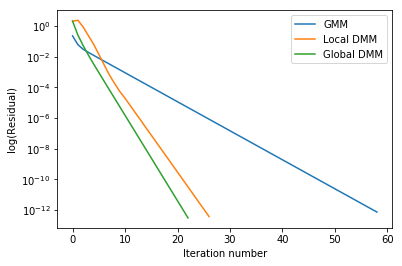

In [14]:
plt.semilogy(linear_gmg.get_gmg_convergence(),label = 'GMM')
plt.semilogy(deep_gmm.get_gmg_convergence(),label= 'Local DMM')
plt.semilogy(DMM_Res,label= 'Global DMM')
plt.xlabel("Iteration number")
plt.ylabel("log(Residual)")
plt.legend()